In [3]:
# imports and data collection functions
import requests
import json
import numpy as np
def get_usgs_sf(state, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=%s&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (state,start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data for',state,'; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_usgs_sf2(state, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=%s&startDT=%s&endDT=%s&siteType=ST&parameterCd=00060&statCd=00003" % (state,start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data for',state,'; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_usgs_sf_code(code, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=%s&&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (code, start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_rainfall_data(n,s,e,w,start,end):
    # GRID CAN BE prism, goes back to 1981
    # if want to go further back, go back to 1950 with nrcc-nn
    #change nrcc-model to prism or nrcc-nn
    # if county mean is removed it just gives values and not counties
    start2 = f'{start[0:4]}-{start[5:7]}-{start[8:10]}'
    end2 = f'{start[0:4]}-{end[5:7]}-{end[8:10]}'
    input_dict = {"bbox":f"{w},{s},{e},{n}","sdate":f"{start2}","edate":f"{end2}","grid":"nrcc-nn","elems":[{"name":"pcpn","interval":[0,0,1]}]}
    #input_dict = {"bbox":"-75,40,-74,41","sdate":"2023-07-01","edate":"2023-07-07","grid":"nrcc-model","elems":[{"name":"pcpn","interval":[0,0,1],"area_reduce":"county_mean"}]}
    req = requests.post("http://grid2.rcc-acis.org/GridData", json = input_dict)
    data = req.json()
    return data

def get_rainfall_data_sum(n,s,e,w, end_date, window):
    end_date2 = f'{end_date[0:4]}-{end_date[5:7]}-{end_date[8:10]}'
    input_dict = {"bbox":f"{w},{s},{e},{n}","date":f"{end_date2}","grid":"nrcc-nn","elems":[{"name":"pcpn","interval":[1,0,0],"duration":window,"reduce":"sum"}]}
    req = requests.post("http://grid2.rcc-acis.org/GridData", json = input_dict)
    data = req.json()
    return data

# Date collection
def get_sf_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
def get_site_code(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteCode"][0]["value"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [float(data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"]), float(data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"])]
    return coordinates

# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_sf_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -10000000 and float(get_gw_value(data, site, i)) < 10000000:
            graph[get_sf_date(data, site, i)] = get_gw_value(data, site, i)
    return graph

def avg_rainfall_data(data):
    info = []
    for dates in data["data"]:
        accum = 0
        total = 0
        for section in dates[1]:
            for item in section:
                if item != -999:
                    total += item
                    accum += 1
        if accum != 0:
            total /= accum
        info.append([dates[0], f'{total:.2f}'])
    return info
        

In [4]:
# get_station_info(data[], "state", "start_date", "end_date")
import datetime as dt

# gathers information on stations for streamflow

def sortkey3(e):
    return e[5]

def get_station_info(data, start_date, end_date):
    stations = []
    start = dt.datetime(int(start_date), 1, 1)
    end = dt.datetime(int(end_date), 12, 31)
    difference = end - start
    print(difference.days)
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        stations.append([i, get_site(data, i) ,f'{reps} total entries', 0, f"SiteCode = {get_site_code(data, i)}", difference.days - reps])
    stations.sort(key=sortkey3)
    nums = []
    site_codes = {}
    for i in stations:
        #if i[5] < 999:
            #print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]}), {i[4]}, Missing days: {i[5]}')
        site_codes[i[4][11:]] =  i[5]
        nums.append(i[0])
    print(site_codes)
    print(len(site_codes))

In [5]:
# graph_comparison(data[], "date", "start_date", "end_date", index_of_site, window_in_wks, if_plotting, percentile) & daily_analysis()
# daily_analysis(graph[], start(dt), end(dt), "date", "end_date", start2(dt))
# change in sf levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np

MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]
# Avg every day
import datetime as dt
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    # returns list of that week average over all years
    date_data = []
    for date in list(graph.keys()):
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data

def daily_no_avg(graph, start, end_date, start2, scope, typ, scopetyp):
    # returns list of that week average over all years
    date_data = []
    for date in list(graph.keys()):
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    # just take first day and next first day
    while start.year < int(end_date):
        lst2 = []
        accum = 0
        min = 1000000
        for i in range(len(date_data)):
            if scopetyp == "mid":
                if date_data[i][0] >= start - dt.timedelta(days=scope) and date_data[i][0] <= start + dt.timedelta(days=scope):
                    lst2.append(date_data[i])
                    if typ == 'avg':
                        accum += date_data[i][1]
                    elif typ == "min" and date_data[i][1] < min:
                        min = date_data[i][1]
            elif scopetyp == "front":
                if date_data[i][0] >= start and date_data[i][0] <= start + dt.timedelta(days=scope):
                    lst2.append(date_data[i])
                    if typ == 'avg':
                        accum += date_data[i][1]
                    elif typ == "min" and date_data[i][1] < min:
                        min = date_data[i][1]
        if len(lst2) >= 2:
            if typ == "avg":
                total_data.append([start2.year, accum/len(lst2)])
            elif typ == "min":
                total_data.append([start2.year, min])
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
    return total_data

def sortkey2(e):
    return e[1]

def graph_comparison(graph, date, start_date, end_date, window, plotting, percentile, scope, typ, scopetyp):
    if len(date) == 5:
        start = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start2 = start + dt.timedelta(weeks=window)
        end2 = start2 + dt.timedelta(days=scope)
    first_set = daily_no_avg(graph[0], start, end_date, start, scope, typ, scopetyp)
    second_set = daily_no_avg(graph[1], start2, end_date, start, scope, typ, scopetyp)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  if i[1] != 0:
                    plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in range(len(plottable)):
        if plotting:
            dct[(str(plottable[i][0]))[2:4]] = plottable[i][1]
        else:
            dct[(str(plottable[i][0]))] = plottable[i]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Streamflow (%s) versus period after" % (date))
        plt.show()
    else:
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]
        else:
            return False

In [8]:
# using_all_weeks(data[], "date", "start_date", "end_date", index_of_site, percent_of_total_outputted)
def sortkey(e):
    return e[0][1]

def get_dates(date, start_date,end_date):
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    week_lst = []
    for i in range(int(end_date) - int(start_date)):
        date = dt.datetime(int(start_date), date.month, date.day)
        for week in range(52):
            date2 = date + dt.timedelta(weeks=week)
            mo = str(date2.month)
            da = str(date2.day)
            if len(mo) == 1:
                mo = "0" + mo
            if len(da) == 1:
                da = '0' + da
            week_lst.append(date2)
        start_date = int(start_date) + 1
    return week_lst

def using_all_weeks(data, date, start_date, end_date, index_of_site, percent, scope, typ, scopetyp, window):
    graph = show_site_data(data, index_of_site, False)
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    total_data = []
    date_data = []
    all_values = []
    for week in range(53):
        date_data.append({})
    for stat in graph:
        new_date = dt.datetime(int(stat[0:4]),int(stat[5:7]),int(stat[8:10]))
        date_data[((new_date.timetuple().tm_yday - 1) // 7)][stat] = graph[stat]

    for week in range(52):
        date2 = date + dt.timedelta(weeks=week)
        # looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        temp1 = {}
        temp2 = {}
        temp1 = {**temp1,**date_data[week]}
        if week + window < 52:
            temp2 = {**temp2,**date_data[week + window]}
        else:
            temp2 = {**temp2,**date_data[(52 - week + window)]}
        if scope // 7 > 1 and scopetyp == "start":
            for additional_week in range((scope // 7) + 1):
                if additional_week + week < 53:
                    temp1 = {**temp1, **date_data[week + additional_week]}
                else:
                    temp1 = {**temp1, **date_data[week + additional_week - 52]}
                if additional_week + week + (scope // 7) < 52:
                    temp2 = {**temp2, **date_data[week + additional_week + (scope // 7)]}
                else:
                    temp2 = {**temp2, **date_data[week + additional_week - 52 + (scope // 7)]}
        # COMBINE NECESSARY WEEKS FOR ANALYSIS
        info = (graph_comparison([temp1, temp2], f"{mo}-{da}", start_date, end_date, window, False, 0, scope, typ, scopetyp))
        # Need to gather full date of entry
        if info:
            for i in range(len(info[0])):
                total_data.append([info[0][i],f"{info[7][i]}/{(info[5])} - {info[7][i]}/{info[6]}"])
                all_values.append(info[0][i])
        #elif scopetype == "XXXX":
            # INSERT DIFFERENT SCOPETYPE HERE
    total_data.sort(key=sortkey)
    all_values = np.array(all_values)
    total_data.append([np.std(all_values), np.mean(all_values)])
    
    #print(str(100 - percent) + "%")
    # TO SHOW 98 PERCENTILE
    #for i in total_data[-1 * int(len(total_data) / (100 / percent)): -1]:
        #print(f'{i[0][0]:.2f}: {i[1]}')
    return total_data[0:(int(int(len(total_data) / (100 / percent))))] + [total_data[-1]]

In [9]:
# coord_clusters(state)
import math
GOOD_SITES_NY = {'01304500': -1, '01305000': -1, '01305500': -1, '01308500': -1, '01315000': -1, '01315500': -1, '01318500': -1, '01321000': -1, '01325000': -1, '01334500': -1, '01336000': -1, '01346000': -1, '01347000': -1, '01350000': -1, '01351500': -1, '01357499': -1, '01357500': -1, '01362500': -1, '01365000': -1, '01371500': -1, '01372500': -1, '01375000': -1, '01413500': -1, '01414500': -1, '01415000': -1, '01417000': -1, '01420500': -1, '01421000': -1, '01426500': -1, '01428500': -1, '01436000': -1, '01437500': -1, '01500000': -1, '01503000': -1, '01509000': -1, '01512500': -1, '01521500': -1, '01523500': -1, '01524500': -1, '01526500': -1, '01529500': -1, '01531000': -1, '03011020': -1, '03014500': -1, '04215500': -1, '04223000': -1, '04227500': -1, '04230500': -1, '04231000': -1, '04231600': -1, '04234000': -1, '04235000': -1, '04243500': -1, '04249000': -1, '04252500': -1, '04256000': -1, '04258000': -1, '04260500': -1, '04262500': -1, '04263000': -1, '04264331': -1, '04266500': -1, '04273500': -1, '04216000': 0, '04237496': 4, '01367500': 177, '01303500': 180, '01423000': 272, '01306500': 352, '01308000': 364, '04217000': 364, '04268000': 364, '04269000': 365, '01304000': 454, '04213500': 547, '01435000': 567, '04229500': 731, '04239000': 863, '01425000': 911, '01358000': 959, '01200000': 1299, '01311500': 1641, '01510000': 1826, '04214500': 1826, '01502500': 2009, '04215000': 2037, '04228500': 2037, '01303000': 2971, '01310500': 3003, '04237500': 3014, '01309500': 3059, '01376800': 3255, '01505000': 3287, '01310000': 3470, '04232050': 3620, '04233000': 3744, '01417500': 3775, '04267500': 4017, '01365500': 4199, '04240100': 4640, '04227000': 4686, '04270000': 4840, '04242500': 4931, '01362200': 5020, '04230380': 5112, '01530500': 5205, '01520500': 5296, '04250750': 5428, '04270200': 5562, '04232482': 5568, '01312000': 5569, '04219000': 6067, '04235250': 6198, '04232000': 6301, '01302500': 6365, '01420980': 6666, '01433500': 6756, '01387450': 6785, '04262000': 6869, '01348000': 7030, '01500500': 7123, '04218000': 7149, '04221000': 7213, '01335754': 7305, '01364500': 7363, '04275000': 7465, '04240010': 7547, '01350180': 7714, '04271500': 7820, '04275500': 7821, '04276500': 7821, '04218518': 8308, '04240180': 8674, '04240105': 8763, '04235500': 8857, '04246500': 8857, '01311000': 8940, '04224775': 8975, '01529950': 9038, '01349000': 9063, '01350140': 9111, '01350120': 9157, '04240120': 9159, '01350355': 9339, '04240300': 9452, '01421900': 9562, '01422500': 9609, '01327750': 9830, '01331095': 9920, '01330000': 9953, '01333500': 10134, '04216418': 10134, '01330500': 10136, '01496500': 10136, '01502000': 10136, '01528000': 10136, '01306460': 10174, '01306495': 10598, '03013000': 10684, '01301500': 10737, '01387400': 10769, '01387420': 10769, '01329490': 10773, '0423205010': 11291, '01376500': 11314, '01309990': 11380, '04268800': 11472, '04245200': 11595, '0142400103': 11753, '01309950': 11771, '04273700': 11956, '04232100': 12086, '01300000': 12145, '01300500': 12145, '01302000': 12145, '01436500': 12145, '01434025': 12210, '01414000': 12484, '01301000': 12876, '04257000': 12876, '04216200': 12934, '01359750': 12966, '01427500': 13147, '04245000': 13241, '01350080': 13346, '01306499': 13474, '04240200': 13693, '01306440': 13890, '01514000': 14208, '01525500': 14244, '04217500': 14244, '01507000': 14246, '04216500': 14335, '0422026250': 14517, '04280450': 14668, '01328000': 14676, '01529000': 14702, '04261000': 14702, '01360640': 14882, '04271815': 15034, '01420000': 15067, '04245236': 15088, '01434017': 15155, '01434498': 15155, '04273800': 15247, '04279000': 15266, '01527000': 15317, '01513500': 15434, '01436690': 15613, '01361000': 15643, '04250200': 15648, '01528700': 15705, '01349150': 15790, '01369500': 15798, '04270510': 15949, '04278300': 16071, '01374701': 16094, '01374901': 16145, '01374821': 16151, '01374941': 16151, '0137462010': 16157, '01374505': 16159, '01374531': 16221, '01319000': 16284, '01428000': 16391, '04233300': 16502, '01361500': 16528, '01369000': 16528, '04265000': 16528, '0137449480': 16708, '01374559': 16708, '01374930': 16708, '04232034': 16743, '01374890': 16776, '04232650': 16802, '04227995': 16874, '01307500': 16893, '04276842': 16999, '01374598': 17028, '04244000': 17073, '04235600': 17074, '04247000': 17122, '01413408': 17139, '01362230': 17152, '01349700': 17161, '01362370': 17197, '01498500': 17249, '0143400680': 17253, '01505500': 17259, '01434021': 17334, '01350101': 17359, '01349711': 17439, '01349810': 17439, '01349950': 17439, '01362342': 17439, '01362497': 17439, '01413398': 17439, '01421618': 17439, '01419500': 17500, '01362198': 17531, '04225000': 17532, '04253295': 17733, '01350035': 17803, '013621955': 17803, '04235440': 17803, '04253294': 17803, '01329500': 17806, '01426000': 17989, '01437000': 17989, '04253500': 17989, '01349705': 18125, '04253296': 18145, '01527500': 18331, '04221500': 18354, '01306000': 18355, '01413088': 18419, '04235299': 18464, '01363382': 18484, '01421610': 18484, '01525981': 18535, '04274000': 18630, '01343060': 18784, '01374581': 18930, '01418500': 19085, '01422000': 19085, '01507500': 19085, '01526000': 19085, '04254500': 19085, '01317000': 19207, '01432900': 19265, '04233286': 19309, '01422747': 19329, '01327500': 19354, '01372300': 19357, '04237946': 19357, '01366650': 19358, '01307000': 19450, '01309000': 19450, '01510500': 19450, '01372200': 19508, '0136230002': 19569, '04265432': 19629, '01302050': 19692, '01358500': 19814, '04254000': 19814, '01314000': 19815, '01370000': 19815, '01373500': 19815, '01425500': 19815, '01497500': 19815, '01499000': 19815, '01501000': 19815, '01501500': 19815, '01508000': 19815, '01508500': 19815, '01522500': 19815, '04222000': 19815, '01371000': 19950, '01368500': 20179, '01366500': 20272, '01511500': 20272, '01374654': 20339, '04232730': 20361, '03011000': 20453, '04218500': 20453, '04235271': 20453, '04217750': 20485, '04270500': 20546, '01302020': 20679, '01372800': 20723, '01356190': 20784, '01374781': 20794, '04234061': 20818, '04237962': 20818, '01508803': 20871, '04232047': 20944, '04247055': 21090, '01434092': 21185, '01423500': 21276, '01424000': 21276, '01364959': 21397, '01505810': 21444, '04220045': 21521, '01311810': 21603, '01424500': 21642, '01374987': 21661, '04220250': 21784, '01359528': 21791, '01502632': 21822, '01502731': 21822, '01513831': 21822, '01530332': 21822, '0423401815': 21886, '01415500': 22007, '0423204920': 22031, '04235150': 22067, '0423205025': 22092, '03010820': 22146, '01362487': 22186, '01359519': 22194, '04256485': 22222, '01350200': 22270, '04258700': 22279, '01302125': 22280, '01425675': 22280, '01313500': 22372, '01349840': 22372, '01422389': 22372, '04274500': 22372, '01354500': 22496, '04219768': 22502, '04232040': 22576, '04234232': 22705, '04245840': 22734, '01421614': 22737, '01422738': 22737, '01362357': 22793, '04233255': 22796, '01362380': 22823, '0422016550': 22874, '04252000': 22897, '01362465': 22945, '01349900': 22949, '01359902': 22977, '01342730': 22978, '01359513': 22980, '01376280': 22983, '01374918': 22989, '0137499350': 22990, '04265100': 23009, '01359924': 23010, '04268600': 23010, '04268700': 23010, '04269500': 23010, '01361570': 23011, '01424108': 23011, '04232046': 23017, '04235276': 23062, '01350032': 23072, '01374976': 23078, '01349541': 23087, '01370500': 23103, '01418000': 23103, '04226000': 23133, '04276770': 23162, '04249200': 23312, '01363556': 23321, '01372850': 23324, '04225500': 23375, '01361200': 23378, '04235300': 23467, '01344000': 23468, '01343403': 23595, '01342602': 23635, '01339060': 23643, '04242640': 23647, '04236800': 23648, '04243783': 23648, '01349527': 23650, '01338000': 23657, '01342682': 23670, '04234254': 23676, '01328770': 23707, '0423406130': 23717, '01354083': 23755, '01427405': 23787, '0134277112': 23812, '0134277114': 23812, '01422700': 23832, '01362192': 23833, '01372100': 23833, '01342743': 23979, '01509150': 24014, '01372065': 24106, '04213450': 24128, '04240503': 24131, '01335500': 24198, '04258500': 24198, '04276069': 24257, '04276645': 24257, '04279040': 24257, '04279125': 24257, '01359133': 24307, '04269043': 24347, '01351000': 24349, '01315170': 24378, '01315226': 24378, '01315227': 24379, '0136219503': 24390, '01362322': 24423, '01362336': 24424, '01362368': 24454, '01514500': 24471, '0424014980': 24472, '01364800': 24530, '01387250': 24571, '04214200': 24622, '04214400': 24622, '04218450': 24622, '01501015': 24637, '04232200': 24675, '01372400': 24683, '04213319': 24691, '04213376': 24692, '04213410': 24713, '04213401': 24733, '04214231': 24733, '04213394': 24734, '0421422210': 24735, '04214060': 24736, '01199490': 24739, '01376270': 24746, '04220223': 24748, '01350212': 24791, '01498620': 24794, '01351298': 24796, '03010800': 24800, '01351200': 24803, '01350500': 24805, '01422779': 24817, '0423204140': 24822, '0423204141': 24823, '01350480': 24825, '0134277121': 24830, '04220500': 24836, '01434105': 24837, '04264700': 24837, '01344500': 24862, '0134277119': 24891, '04222900': 24928, '04228900': 24928, '04224650': 24945, '04221600': 24959, '01368050': 24974, '04220470': 24988, '04221720': 24988, '01370520': 25000, '0424015305': 25037, '01370600': 25049, '04265605': 25063, '01373600': 25080, '01365505': 25091, '01365550': 25092, '04234270': 25109, '04253275': 25109, '0426545295': 25109, '01362090': 25171, '01365100': 25189, '01359135': 25190, '01415460': 25194, '04232630': 25202, '04234018': 25202, '04234055': 25202, '04219940': 25220, '0134277123': 25234, '04213440': 25263, '01416500': 25294, '04234398': 25294, '0423245850': 25301, '04234200': 25323, '04235890': 25336, '04268200': 25406, '01433005': 25414, '01359918': 25445, '04221820': 25445, '04276895': 25458, '04276920': 25458, '0131199050': 25461, '0425040001': 25470, '04235820': 25471, '01376534': 25477, '0143402265': 25486, '01434013': 25487, '0427386410': 25518, '04273996': 25519, '04274051': 25524, '01436655': 25527, '01309680': 25545, '01437100': 25545, '01425805': 25547, '01434176': 25547, '01362182': 25566, '04237944': 25566, '01374420': 25568, '01374480': 25568, '01376600': 25568, '01376850': 25568, '01377300': 25568, '01390200': 25568, '01434086': 25568, '04268390': 25568, '04256480': 25574, '04237575': 25592, '01359150': 25598, '0426545290': 25628, '01373690': 25638, '01419000': 25659, '04241200': 25659, '04256460': 25659, '04240150': 25676, '0423205023': 25679, '01329650': 25728, '01387095': 25743, '01372051': 25751, '01376558': 25768, '01437349': 25771, '01530380': 25777, '04219915': 25834, '0422018610': 25834, '04233700': 25840, '01434080': 25841, '04249910': 25851, '01499050': 25871, '01507470': 25871, '01507975': 25871, '01513840': 25871, '01525750': 25871, '01526495': 25871, '01526980': 25871, '04213492': 25898, '01499470': 25902, '04245250': 25902, '04270800': 25931, '01374440': 25933, '01376900': 25933, '01377200': 25933, '01387300': 25933, '01387480': 25933, '01390300': 25933, '01434076': 25933, '01434084': 25933, '0423368620': 25949, '01327000': 25959, '01527050': 25963, '04240145': 25964, '0424016205': 25964, '0424016825': 25964, '0424016975': 25964, '01315081': 25968, '01513790': 25992, '04230650': 26008, '04218999': 26019, '01362100': 26048, '04231401': 26049, '03012834': 26052, '04232053': 26056, '0422027430': 26072, '01372040': 26085, '04213508': 26097, '01425642': 26113, '04232076': 26125, '04279001': 26139, '01434072': 26144, '01311992': 26145, '01434073': 26145, '04253000': 26175, '04213442': 26199, '04233678': 26206, '01434500': 26213, '04218601': 26222, '04218700': 26223, '01434087': 26226, '01362297': 26227, '01349858': 26240, '0423527080': 26259, '01508962': 26265, '03011550': 26296, '04237950': 26296, '01376275': 26297, '03013800': 26298, '01437400': 26331, '01513719': 26358, '04223500': 26390, '04270700': 26417, '04269050': 26418, '04218592': 26449, '01424998': 26484, '01513720': 26509, '01362232': 26526, '04219767': 26576, '04274185': 26577, '01337005': 26595, '01344795': 26623}
GOOD_SITES_VT = {'01134500': -1, '01135500': -1, '01138500': -1, '01139000': -1, '01144000': -1, '01151500': -1, '01334000': -1, '04280000': -1, '04282000': -1, '04282500': -1, '04285500': -1, '04286000': -1, '04287000': -1, '04288000': -1, '04289000': -1, '04290500': -1, '04292000': -1, '04292500': -1, '04293000': -1, '04293500': -1, '04296500': -1, '01142500': 243, '04296000': 637, '01155500': 2190, '01139800': 3072, '01133000': 6574, '01154000': 6818, '01153000': 10226, '04284000': 11048, '01141500': 12144, '01156000': 12144, '01150900': 13137, '01153550': 13421, '01153500': 13970, '01329000': 14062, '01135000': 14336, '04282525': 14668, '04282650': 14668, '04282780': 14668, '04282795': 14668, '04294000': 14668, '01135300': 14882, '01135150': 14949, '04281500': 16527, '04280350': 17588, '01156500': 17988, '04288225': 18535, '04288230': 18535, '04292700': 18547, '04294300': 18841, '01167800': 21325, '04292810': 21457, '04296280': 22110, '04292750': 22206, '04294140': 22221, '04282700': 22415, '01155300': 22416, '04280300': 22421, '01155200': 22444, '01134800': 22541, '04292100': 22549, '04282815': 22643, '01150800': 22644, '04287300': 22644, '04296200': 22814, '04290335': 23662, '04282813': 24042, '04292795': 24164, '04288295': 24346, '01152800': 24470, '01155910': 24470, '04292770': 24518, '01142000': 24563, '04293900': 25140, '04282629': 25461, '04282586': 25470, '01140817': 25584, '04293600': 25859, '04293700': 25861, '04293795': 25864, '04280800': 25870, '04290580': 25870, '04290610': 25870, '04282581': 25880, '04293200': 25893, '04293430': 25898, '01139838': 25932, '01139830': 25949, '01140570': 25979, '01140575': 25979, '01140580': 25979, '01140590': 25979, '01140600': 25979, '01140000': 26024, '01139833': 26175, '04290575': 26209, '04282800': 26223, '04282805': 26233, '04280910': 26236, '04292800': 26267, '01140820': 26333, '01139500': 26389, '04282576': 26494, '01135100': 26582}
GOOD_SITES_ME = {'01010500': -1, '01011000': -1, '01013500': -1, '01014000': -1, '01017000': -1, '01018500': -1, '01019000': -1, '01022500': -1, '01030500': -1, '01031500': -1, '01034500': -1, '01038000': -1, '01042500': -1, '01046500': -1, '01047000': -1, '01054500': -1, '01055000': -1, '01057000': -1, '01059000': -1, '01066000': -1, '01010000': 272, '01055500': 1764, '01034000': 2556, '01015800': 2812, '01048000': 2823, '01049000': 3378, '01021000': 3559, '01049500': 4382, '01054200': 5303, '01060000': 5476, '01029500': 6208, '01021200': 6809, '01064000': 8126, '01069500': 8817, '01065500': 9587, '01018000': 10311, '01033000': 11108, '01054300': 11386, '01030000': 11414, '01043500': 11579, '01010070': 12325, '01049265': 13056, '01021500': 13658, '01046000': 14152, '01020000': 14336, '01041000': 14679, '01066500': 14682, '01058500': 14696, '01016500': 14853, '01023000': 15797, '01033500': 15797, '01035000': 15797, '01036500': 15797, '01045000': 15797, '01022294': 16244, '01063310': 16708, '01031300': 17074, '01031450': 17372, '01029200': 17621, '01037380': 17691, '01022295': 17695, '01021480': 17742, '01064118': 17896, '01044550': 18108, '01017550': 18200, '01027200': 18870, '01059800': 19195, '01021470': 19226, '01049300': 19408, '01072500': 19449, '01022260': 19515, '01017960': 19630, '01017900': 19780, '01024200': 20039, '01018035': 20269, '01036390': 20274, '01022840': 20570, '01049373': 21183, '01068910': 21281, '01017290': 21335, '01018009': 21335, '01048220': 21335, '01067950': 21346, '01031510': 21365, '01047200': 21365, '01030350': 21457, '01017060': 21518, '01069700': 21518, '01049550': 21549, '01031600': 21550, '01047150': 21640, '01037000': 21905, '01049130': 22503, '01064140': 22578, '01022000': 23467, '01036000': 23467, '01047730': 23860, '01022860': 23949, '01022835': 23962, '01049205': 24105, '01063100': 24183, '01022330': 24363, '01027240': 24385, '01049396': 24471, '01058005': 24911, '01012520': 25201, '01056505': 25232, '01056400': 25413, '01056480': 25490, '01055220': 25567, '01059500': 25567, '01012525': 25601, '01010100': 25724, '01021230': 25798, '01022250': 25799, '01022210': 25932, '01012515': 25962, '01012570': 25963, '01049221': 25984, '01059160': 26057, '01049218': 26079, '01064158': 26087, '01022800': 26113, '01059090': 26116, '01068980': 26116, '01021466': 26189, '01069800': 26192, '01049270': 26207, '01063452': 26235, '01037700': 26256, '01067851': 26297, '01067853': 26297, '01057510': 26319, '010228955': 26409}
GOOD_SITES_NH = {'01052500': -1, '01053500': -1, '01054000': -1, '01064500': -1, '01073000': -1, '01073500': -1, '01076500': -1, '01078000': -1, '01081000': -1, '01092000': -1, '01129500': -1, '01131500': -1, '01137500': -1, '01152500': -1, '01154500': -1, '01161000': -1, '01144500': 718, '01158000': 2190, '01130000': 2396, '01129200': 2464, '01150500': 6665, '01080500': 7917, '01081500': 8400, '01086000': 8400, '01075000': 8765, '01076000': 8765, '01082000': 8765, '01094000': 9130, '01085500': 9895, '01077000': 9953, '01158600': 10465, '01157000': 10519, '01091000': 10847, '01085800': 11189, '01093800': 11533, '01064300': 11756, '01065000': 11779, '01128500': 11779, '01083000': 12144, '01087000': 12144, '01072100': 13240, '010965852': 13421, '01141800': 13452, '01089000': 13513, '01089500': 13557, '01075800': 13741, '01085000': 13878, '01089100': 13940, '01091500': 14244, '01160000': 15401, '01138000': 15431, '01074520': 15773, '01064801': 15795, '01160350': 16160, '01145000': 16162, '01155000': 16162, '01064400': 16438, '01072800': 16494, '01088000': 16527, '01090800': 16964, '01073587': 16978, '01073600': 18029, '01084000': 18415, '01100505': 18540, '01127880': 18929, '01084500': 19084, '01093000': 19084, '01073785': 19180, '01072870': 19636, '01129440': 20087, '01100561': 20368, '01093852': 20751, '01073319': 21365, '01077400': 21438, '010735562': 21452, '01053600': 21457, '01154950': 21807, '010642505': 21809, '01072850': 21822, '01064800': 22907, '01054114': 22943, '01158500': 23589, '01158110': 23705, '01089925': 24013, '01079602': 24332, '01079900': 24387, '01072880': 24927, '01152010': 25413, '01074500': 25476, '0109650657': 25567, '01079600': 25717, '01075500': 25780, '01073460': 25818, '01093875': 25824, '01137940': 25914, '01064485': 25978, '01073848': 26007, '01096587': 26035, '010965844': 26055, '01073810': 26164, '01073750': 26165, '010965817': 26188, '01100549': 26200, '01159600': 26216, '01090500': 26389}
GOOD_SITES_CT = {'01119500': -1, '01121000': -1, '01122500': -1, '01124000': -1, '01127000': -1, '01127500': -1, '01184000': -1, '01188000': -1, '01193500': -1, '01196500': -1, '01199000': -1, '01200500': -1, '01204000': -1, '01205500': -1, '01208500': -1, '01187300': 365, '01123000': 637, '01186500': 1020, '01192500': 1783, '01186000': 2098, '01122000': 2190, '01189000': 2494, '01118300': 3194, '01206900': 3925, '01199050': 4290, '01209700': 4625, '01208950': 5386, '01208990': 5386, '01184490': 6273, '01194500': 7297, '01189995': 7942, '01124151': 9279, '01125500': 9495, '01196620': 9764, '01208925': 9850, '01191000': 10050, '01188090': 10134, '01208873': 10979, '01192883': 11292, '01184100': 11448, '01195100': 11629, '01205700': 11854, '01205600': 12217, '01203600': 12948, '01203000': 13161, '01195490': 13823, '01194000': 14865, '01190500': 15064, '01209500': 15248, '01120500': 15332, '01187800': 15962, '01187850': 16890, '01209901': 17060, '01203510': 17732, '01209761': 18030, '011230695': 18346, '01187400': 18353, '01203805': 18533, '01202501': 18535, '01198500': 18624, '01184500': 18707, '01126000': 18709, '01126500': 18712, '01120000': 18713, '01125490': 18726, '01125100': 18783, '01199200': 18901, '01201487': 18937, '01195200': 19294, '012095493': 19444, '01192890': 19660, '01204800': 20083, '01196561': 20114, '01201500': 20545, '01121330': 20644, '01193800': 20721, '01120790': 20726, '012035055': 20726, '01192600': 20818, '01195000': 20911, '01187980': 21214, '01209005': 21499, '01201930': 21518, '01189500': 21641, '01190200': 21756, '01190300': 21757, '01190600': 21757, '01119382': 21781, '01190100': 21787, '01212500': 21821, '01209105': 21865, '01126600': 21908, '01189390': 21912, '01206400': 21913, '01186100': 21914, '01126950': 22214, '01191500': 22371, '01196580': 22614, '01201190': 23009, '01192650': 23010, '01192700': 23010, '01196210': 23043, '01206000': 23102, '01206500': 23102, '01186400': 23370, '01195146': 23375, '011277905': 23656, '01199290': 24325, '01192370': 24463, '01212100': 24470, '01192480': 24471, '01202500': 24471, '01187000': 24563, '01192704': 24652, '01119320': 24775, '01201510': 24830, '01119280': 24836, '01187680': 24836, '01189180': 24836, '01189200': 24836, '01189210': 24836, '01125415': 24861, '01198860': 25060, '01208012': 25100, '011277914': 25121, '011277916': 25196, '01119384': 25200, '01196626': 25201, '01198800': 25201, '01198851': 25201, '01198870': 25201, '01198880': 25201, '01190055': 25240, '01208999': 25352, '01195117': 25422, '01184280': 25525, '01187830': 25540, '01118668': 25565, '01209785': 25567, '01118700': 25602, '01195399': 25616, '01127821': 25646, '01193465': 25659, '011277696': 25694, '01193450': 25703, '01208171': 25747, '01184205': 25757, '01190057': 25758, '01190650': 25758, '01118400': 25855, '01119600': 25870, '01119820': 25870, '01195500': 25923, '01196100': 25923, '01196150': 25923, '01196000': 25927, '01196680': 25927, '01183950': 25931, '01184250': 25931, '01184300': 25931, '01198240': 25931, '01198300': 25931, '01198700': 25931, '01199030': 25931, '01199033': 25931, '01201420': 25931, '01201470': 25931, '01196220': 25932, '01208850': 25933, '01127680': 26084, '01127750': 26084, '01125600': 26114, '01126910': 26114, '01126923': 26114, '01190620': 26123, '01127729': 26129, '01192610': 26237, '01120800': 26296, '01195339': 26296, '01119260': 26297, '01119480': 26297, '01211110': 26297, '01211600': 26297, '01209900': 26340, '011844549': 26468, '01208872': 26476, '01184455': 26515, '011844548': 26563, '01184470': 26615, '01183994': 26616, '01190095': 26625, '01209753': 26625, '01209775': 26625, '01196259': 26626, '01184325': 26627, '01192692': 26638}
GOOD_SITES_RI = {'01111500': -1, '01112500': -1, '01114500': -1, '01116000': -1, '01116500': -1, '01117000': -1, '01117500': -1, '01118000': -1, '01118500': -1, '01114000': 4996, '01117800': 5499, '01111300': 5903, '01117350': 7771, '01117420': 8218, '01117468': 9102, '01109403': 13421, '01115630': 14374, '01106000': 15937, '01115187': 16150, '01115098': 16243, '01117370': 17804, '01115770': 18763, '01117430': 19049, '01113895': 19956, '01116905': 20908, '01115114': 21457, '01115190': 21457, '01115265': 21457, '01115276': 21457, '01115280': 21457, '01115170': 21459, '01115183': 21459, '01115110': 21460, '01117600': 22403, '01113695': 22933, '01112700': 23260, '01115100': 23261, '01126200': 23262, '01116300': 23296, '01111400': 23577, '01115184': 23637, '01115120': 24437, '01115297': 24456, '01115670': 24803, '01115275': 24822, '01117410': 24901, '011173545': 24982, '01111410': 25132, '01117472': 25423, '01117100': 25542, '01115900': 25748, '01118010': 25799, '01118360': 25809, '01115185': 25839, '01117424': 25851, '01115278': 25853, '01117471': 25862, '01113760': 25963, '01112268': 25997, '01112382': 25997, '01113710': 26639, '01115500': 26662}
GOOD_SITES_MA = {'01094500': -1, '01096000': -1, '01096500': -1, '01097000': -1, '01099500': -1, '01100000': -1, '01101000': -1, '01101500': -1, '01102000': -1, '01103500': -1, '01104000': -1, '01104500': -1, '01105000': -1, '01109000': -1, '01110000': -1, '01162000': -1, '01162500': -1, '01166500': -1, '01169000': -1, '01170000': -1, '01170500': -1, '01171500': -1, '01172500': -1, '01173000': -1, '01173500': -1, '01174500': -1, '01175500': -1, '01176000': -1, '01177000': -1, '01181000': -1, '01183500': -1, '01185500': -1, '01197000': -1, '01197500': -1, '01331500': -1, '01332500': -1, '01333000': -1, '01102500': 0, '01168500': 0, '01105500': 1003, '01179500': 1825, '01180500': 3060, '01104200': 3523, '01175670': 3986, '01124500': 4939, '01097300': 4953, '01100600': 5071, '01163200': 5447, '01105600': 5982, '01169900': 6011, '01109060': 6024, '01105730': 6031, '01105870': 6055, '01109070': 6182, '01108000': 6325, '01170100': 6481, '01125000': 8118, '01094400': 8308, '01123600': 9037, '01098530': 10895, '01332000': 11779, '01105585': 12671, '01123360': 12690, '01198000': 12825, '01105880': 12960, '01174900': 13432, '01110500': 13605, '011058837': 14152, '01161500': 14360, '01174600': 14529, '01108500': 14593, '01165500': 14701, '01174000': 14701, '01171300': 15594, '01174565': 16078, '01102345': 16129, '01109500': 16162, '01095220': 16181, '01100568': 16708, '01105933': 16708, '011055566': 17105, '01095375': 17124, '01104430': 17439, '01103280': 17481, '01180000': 17697, '01104455': 17998, '01104480': 18113, '01168151': 18131, '01104460': 18585, '01105608': 18984, '01105606': 18988, '01165300': 19022, '01104415': 19153, '01109730': 19173, '01172010': 19265, '01104475': 19714, '01172003': 19793, '01105554': 19848, '01198125': 20165, '01095000': 20180, '01103025': 20365, '01108410': 20449, '01105583': 20542, '01111212': 20647, '01105876': 20877, '01100627': 20963, '01124750': 21183, '01180800': 21214, '01098500': 21539, '01185100': 21866, '01104370': 21921, '01123500': 22006, '01096910': 22157, '01104420': 22233, '01101300': 22300, '01107000': 22302, '01173260': 22303, '01109200': 22305, '01100700': 22307, '01171800': 22310, '01331400': 22310, '01197300': 22340, '01105917': 22369, '01105638': 22402, '01095503': 22460, '01095434': 22552, '01124350': 22769, '01103455': 22842, '01183450': 23050, '01103220': 23365, '01168250': 23702, '01105557': 23740, '011056081': 23822, '01104453': 24241, '01103305': 24420, '01096885': 24489, '01096840': 24490, '01096835': 24533, '01166105': 24549, '01106500': 24813, '01104410': 24831, '01104405': 24859, '01174570': 24970, '01174575': 24972, '01096503': 25008, '01097480': 25021, '01105885': 25045, '01111050': 25069, '01105800': 25119, '01108320': 25126, '01104850': 25304, '01172800': 25312, '01109220': 25334, '01172680': 25369, '011058756': 25396, '01097380': 25462, '010965995': 25479, '01176780': 25487, '01170930': 25545, '01096906': 25546, '01197015': 25588, '01171100': 25597, '01171000': 25617, '01098710': 25622, '01109090': 25645, '01103010': 25769, '01198200': 25792, '01105700': 25849, '01106900': 25849, '01109439': 25901, '01101400': 25902, '01111225': 25905, '01101344': 25914, '011020308': 25962, '01102029': 25970, '01174050': 25990, '01105895': 26004, '01105883757': 26022, '01198122': 26023, '01111000': 26024, '01178000': 26024, '01178500': 26024, '01098340': 26049, '01198075': 26049, '01198030': 26054, '01198070': 26054, '0110588374': 26069, '01098320': 26073, '01098450': 26073, '01098360': 26080, '01104440': 26107, '0110588340': 26121, '0110588332': 26125, '01100890': 26145, '01104615': 26168, '01104630': 26185, '01104660': 26227, '01105660': 26235, '01102065': 26250, '01168639': 26256, '01168640': 26256, '01104640': 26280, '011058835951': 26282, '01107400': 26297, '01103040': 26312, '01105765': 26336, '0110587880': 26382, '0110588364': 26414, '01104687': 26485, '01103038': 26596}

def sort_by_x(e):
    return e[1][0]
def sort_by_y(e):
    return e[1][1]
def sort_by_distance(e):
    return e[0]
def sort_prox(e):
    return e[1]

EXPONENT = 2
MULTIPLIER = 750
DIVIS = 365

def coord_clusters2(state,num_clusters, data):
    # only works for 3 currently, can fix though if desired
    num_of_stations = 3
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        match state:
            case "NY":
                site_lst = GOOD_SITES_NY
            case "VT":
                site_lst = GOOD_SITES_VT
            case "NH":
                site_lst = GOOD_SITES_NH
            case "MA":
                site_lst = GOOD_SITES_MA
            case "CT":
                site_lst = GOOD_SITES_CT
            case "RI":
                site_lst = GOOD_SITES_RI
            case "ME":
                site_lst = GOOD_SITES_ME
        stations.append([i,get_coordinates(data,i), site_lst[get_site_code(data,i)]])
    x_lst = stations.copy()
    y_lst = stations.copy()
    x_lst.sort(key = sort_by_x)
    y_lst.sort(key = sort_by_y)
    all_circles = []
    # HOW TO LOCATE 3 CLOSEST WITHOUT ITERATING THROUGH EVERY SINGLE ONE
    for i in range(len(data["value"]["timeSeries"])):
        # GIVES STARTING POINT IN LIST FOR STATION
        x_start = (next((n for n, sublist in enumerate(x_lst) if sublist[0] == i), None))
        y_start = (next((n for n, sublist in enumerate(y_lst) if sublist[0] == i), None))
        # WITH STARTING POINT, START LOOKING IN ALL 4 DIRECTIONS. DO FIRST 3, THEN JUST SWAP OUT LARGEST FOR SMALLER ONE AS PROGRESSES
        accum = 0
        nearest_prox = []
        r = 1000

        # min distance searched updates when the difference between whatever direction looking is less than curr value
        # if min distance searched is greater than radii, exit
        points = []
        while True:
            min_distance_searched = 1000
            accum += 1
            if x_start + accum < len(data["value"]["timeSeries"]) and x_lst[x_start + accum][0] not in points: # and if not already in list
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # if r is less than nearest max, add to nearest and remove nearest max
            if x_start - accum >= 0 and x_lst[x_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # Look down x
            if y_start + accum < len(data["value"]["timeSeries"]) and y_lst[y_start + accum][0] not in points:
                if len(nearest_prox) < num_of_stations:       
                    nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                if abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look up y
            if y_start - accum >= 0 and y_lst[y_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                if abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
            if min_distance_searched > math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2):
                break
        all_circles.append([math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2), i, nearest_prox[0][0], nearest_prox[1][0], nearest_prox[2][0], get_site_code(data,i), get_site_code(data,nearest_prox[0][0]), get_site_code(data,nearest_prox[1][0]), get_site_code(data,nearest_prox[2][0])])
    all_circles.sort(key = sort_by_distance)
    alternate_lst = []
    for i in all_circles:
        if get_site_code(data, i[1]) in site_lst and get_site_code(data, i[2]) in site_lst and get_site_code(data, i[3]) in site_lst and get_site_code(data, i[4]) in site_lst:
            alternate_lst.append(i)

    # SEGMENTS FOR STATE! CURRENTLY FOR NY!
    segments = []
    j = 0
    for k in alternate_lst:
        # first region
        if get_coordinates(data, k[1])[1] < -78:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        # second region
        if get_coordinates(data, k[1])[1] > -78 and get_coordinates(data, k[1])[1] < -76:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        # third region
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] > 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        # fourth region
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] < 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    return segments
    

In [10]:
# mapping(state, num_clusters, highlighted)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def mapping(state, num_clusters, highlighted):
    projection = ccrs.PlateCarree()

    # Set the extent to focus on State (longitude and latitude)
    match state:
        case "NY":
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.747099, -79.901600, 40.450066, 45.104038])
        case "VT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.743431, -73.530463, 42.724495, 45.052165])
        case "MA":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "ME":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-66.868726, -72.033859, 42.955197, 47.488230])
        case "CT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "RI":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "NH":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-70.579929, -72.611172, 42.661347, 45.407703])
    # Add geographical features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Add state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    data = get_usgs_sf2(state, "2023-01-01", "2023-01-02")
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        #if get_site_code(data, i) in GOOD_SITES:
            stations.append([get_coordinates(data,i)[1],get_coordinates(data,i)[0], i])
    lst2 = []
    lst3 = []
    lst = coord_clusters2(state, num_clusters, data)
    for i in lst:
        lst3.append(i[1])
        lst2.append(i[2])
        lst2.append(i[3])
        lst2.append(i[4])
   # Plot the points
    stations_2 = []
    stations_3 = []
    highlighted2 = []
    for lon, lat, index in stations:
        if index in highlighted:
            highlighted2.append([lon, lat])
        elif index in lst3:
            stations_3.append([lon, lat])
        elif index in lst2:
            stations_2.append([lon, lat])
        else:
            ax.plot(lon, lat, marker='o', color="black", markersize=1, transform=ccrs.Geodetic())
    for i in stations_2:
        if [i[0], i[1]] not in stations_3 and [i[0], i[1]]:
            ax.plot(i[0], i[1], marker='o', color="red", markersize=2, transform=ccrs.Geodetic())
    for i in stations_3:
        ax.plot(i[0], i[1], marker='o', color="green", markersize=2, transform=ccrs.Geodetic())
    for i in highlighted2:
        ax.plot(i[0], i[1], marker='o', color="blue", markersize=2, transform=ccrs.Geodetic())
    plt.title(f'Map of {state}')
    plt.show()

In [11]:
# cluster_using_all_wks()
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

def sort_by_date(e):
     return e[1][0:4]

def cluster_using_all_wks(state, cluster, cluster2, start_date, end_date, percentile, scope, typ, scopetyp, window):
    rain_days_back = 30
    data = get_usgs_sf2(state, "2023-01-01", "2023-01-02")
    a = coord_clusters2(state, cluster, data)[cluster2]
    stations = a[5:9]
    nums = a[1:5]
    if percentile == 1 and window == 4:
        mapping(state, cluster, nums)
    lats = []
    longs = []
    comparison = []
    value_data = []
    for code in stations:
        data = get_usgs_sf_code(code, start_date, end_date)
        if percentile == 1 and window == 4:
            print(f"Station {code}, Coordinates: {get_coordinates(data, 0)}, Number of Values = {num_of_reps(data,0)}")
        comparison.append(using_all_weeks(data, "01-01", start_date, end_date, 0, percentile, scope, typ, scopetyp, window))
        value_data.append(comparison[-1].pop())
        # make box for cluster
        lats.append(get_coordinates(data, 0)[0])
        longs.append(get_coordinates(data, 0)[1])
     # calculate box
    s = min(lats)
    n = max(lats)
    e = max(longs)
    w = min(longs)
    datapoints = []
    for i in range(10):
        for station in range(4):
            datapoints.append([f"{comparison[station][i][0][1]:.2f}, {comparison[station][i][1]}", ((comparison[station][i][0][1] - value_data[station][1]) / value_data[station][0])])
    datapoints.sort(key=sortkey2)
    templst=[]
    for j in datapoints[:20]:
        templst.append(j[0])
    #print(templst)
    
    year_accum = []
    year_accum2 = []
    for i in range(int(end_date)-int(start_date)):
        year_accum.append(0)
        year_accum2.append(0)
    month_accum = [0,0,0,0,0,0,0,0,0,0,0,0]
    for lst in comparison:
        for lst2 in lst:
            month_accum[int(lst2[1][5:7]) - 1] += 1

    plt.bar(MONTHS, month_accum, color ="blue")
    plt.title(f"Streamflow: {percentile} percent between {start_date}-{end_date}")
    plt.xlabel("Month")
    plt.ylabel("Number of Occurances")
    plt.show()

    if percentile == 10:
        print(f"1%: {comparison[0][int(len(comparison[0]) / 10)][0][0]:.2f}, ({comparison[0][int(len(comparison[0]) / 10)][0][1]:.3f}) ({comparison[0][int(len(comparison[0]) / 10)][1]}) | {comparison[1][int(len(comparison[1]) / 10)][0][0]:.2f}, ({comparison[1][int(len(comparison[1]) / 10)][0][1]:.3f}) ({comparison[1][int(len(comparison[0]) / 10)][1]}) | {comparison[2][int(len(comparison[2]) / 10)][0][0]:.2f}, ({comparison[2][int(len(comparison[2]) / 10)][0][1]:.3f}) ({comparison[2][int(len(comparison[0]) / 10)][1]}) | {comparison[3][int(len(comparison[3]) / 10)][0][0]:.2f}, ({comparison[3][int(len(comparison[3]) / 10)][0][1]:.3f}) ({comparison[3][int(len(comparison[0]) / 10)][1]}) ")
        print(f"2%: {comparison[0][int(len(comparison[0]) / 5)][0][0]:.2f}, ({comparison[0][int(len(comparison[0]) / 5)][0][1]:.3f}) ({comparison[0][int(len(comparison[0]) / 5)][1]}) | {comparison[1][int(len(comparison[1]) / 5)][0][0]:.2f}, ({comparison[1][int(len(comparison[1]) / 5)][0][1]:.3f}) ({comparison[1][int(len(comparison[0]) / 5)][1]}) | {comparison[2][int(len(comparison[2]) / 5)][0][0]:.2f}, ({comparison[2][int(len(comparison[2]) / 5)][0][1]:.3f}) ({comparison[2][int(len(comparison[0]) / 5)][1]})| {comparison[3][int(len(comparison[3]) / 5)][0][0]:.2f}, ({comparison[3][int(len(comparison[3]) / 5)][0][1]:.3f}) ({comparison[3][int(len(comparison[0]) / 5)][1]})")
        print(f"5%: {comparison[0][int(len(comparison[0]) / 2)][0][0]:.2f}, ({comparison[0][int(len(comparison[0]) / 2)][0][1]:.3f}) ({comparison[0][int(len(comparison[0]) / 2)][1]}) | {comparison[1][int(len(comparison[1]) / 2)][0][0]:.2f}, ({comparison[1][int(len(comparison[1]) / 2)][0][1]:.3f}) ({comparison[1][int(len(comparison[0]) / 2)][1]})| {comparison[2][int(len(comparison[2]) / 2)][0][0]:.2f}, ({comparison[2][int(len(comparison[2]) / 2)][0][1]:.3f}) ({comparison[2][int(len(comparison[0]) / 2)][1]})| {comparison[3][int(len(comparison[3]) / 2)][0][0]:.2f}, ({comparison[3][int(len(comparison[3]) / 2)][0][1]:.3f}) ({comparison[3][int(len(comparison[0]) / 2)][1]})")
        print(f"10%: {comparison[0][-1][0][0]:.2f}, ({comparison[0][-1][0][1]:.3f}) ({comparison[0][-1][1]}) | {comparison[1][-1][0][0]:.2f}, ({comparison[1][-1][0][1]:.3f}) ({comparison[1][-1][1]})| {comparison[2][-1][0][0]:.2f}, ({comparison[2][-1][0][1]:.3f}) ({comparison[2][-1][1]})| {comparison[3][-1][0][0]:.2f}, ({comparison[3][-1][0][1]:.3f}) ({comparison[3][-1][1]})")
        for lst in comparison:
            for lst2 in lst[0:int(len(lst) / (10))]:
                year_accum[int(lst2[1][0:4]) - int(start_date)] += 1
        all_rainfall = []
        for dates in get_dates("01-01", start_date, end_date):
            dates2 = dates + dt.timedelta(weeks = scope // 7)
            dates3 = dates2 + dt.timedelta(weeks = window)
            all_rainfall.append([f"{str(dates.year)}/{dates.strftime('%m/%d')} - {str(dates3.year)}/{dates3.strftime('%m/%d')}", float(avg_rainfall_data(get_rainfall_data_sum(n,s,e,w,str(dates3.year) + "/" + dates3.strftime("%m/%d"), rain_days_back))[0][1]) - float(avg_rainfall_data(get_rainfall_data_sum(n,s,e,w,str(dates2.year)  + "/"+ dates2.strftime("%m/%d"), rain_days_back))[0][1])])
            if len(all_rainfall) > 1:
                if all_rainfall[-1][0][0:4] != all_rainfall[-2][0][0:4]:
                    print(".", end="")
        all_rainfall.sort(key=sort_prox)
        month_accum = [0,0,0,0,0,0,0,0,0,0,0,0]
        for lst in all_rainfall[0:int(len(all_rainfall) / (100 / 1))]:
            month_accum[int(lst[0][5:7]) - 1] += 1
            year_accum2[int(lst[0][0:4]) - int(start_date)] += 1
        plt.bar(MONTHS, month_accum, color ="green")
        plt.title(f"Rainfall: 1 percent between {start_date}-{end_date}")
        plt.xlabel("Month")
        plt.ylabel("Number of Occurances")
        plt.show()
        month_accum = [0,0,0,0,0,0,0,0,0,0,0,0]
        for lst in all_rainfall[0:int(len(all_rainfall) / (100 / 2))]:
            month_accum[int(lst[0][5:7]) - 1] += 1
        plt.bar(MONTHS, month_accum, color ="green")
        plt.title(f"Rainfall: 2 percent between {start_date}-{end_date}")
        plt.xlabel("Month")
        plt.ylabel("Number of Occurances")
        plt.show()
        month_accum = [0,0,0,0,0,0,0,0,0,0,0,0]
        for lst in all_rainfall[0:int(len(all_rainfall) / (100 / 5))]:
            month_accum[int(lst[0][5:7]) - 1] += 1
        plt.bar(MONTHS, month_accum, color ="green")
        plt.title(f"Rainfall: 5 percent between {start_date}-{end_date}")
        plt.xlabel("Month")
        plt.ylabel("Number of Occurances")
        plt.show()
        month_accum = [0,0,0,0,0,0,0,0,0,0,0,0]
        for lst in all_rainfall[0:int(len(all_rainfall) / (100 / 10))]:
            month_accum[int(lst[0][5:7]) - 1] += 1
        plt.bar(MONTHS, month_accum, color ="green")
        plt.title(f"Rainfall: 10 percent between {start_date}-{end_date}")
        plt.xlabel("Month")
        plt.ylabel("Number of Occurances")
        plt.show()
        print(f"1%: {all_rainfall[int(len(all_rainfall) / (100 / 1))][1]:.3f}")
        print(f"2%: {all_rainfall[int(len(all_rainfall) / (100 / 2))][1]:.3f}")
        print(f"5%: {all_rainfall[int(len(all_rainfall) / (100 / 5))][1]:.3f}")
        print(f"10%: {all_rainfall[int(len(all_rainfall) / (100 / 10))][1]:.3f}")

        templst = []
        for i in all_rainfall[0:10]:
            templst.append(f"{i[1]:.3f}, {i[0]}")
            
        print(templst)
        plt.scatter((range(int(start_date), int(end_date))), year_accum, color ="red")
        plt.scatter((range(int(start_date), int(end_date))), year_accum2, color ="green")
        plt.title(f"Red = SF, Green = Precip: 1 percent between {start_date}-{end_date}")
        plt.xlabel("Year")
        plt.ylabel("Number of Occurances")
        plt.show()

        # UNCOMMENT THIS SECTION TO PRINT THE RAIN EVENTS DURING THE TOP STREAMFLOW TIMES
        '''
        for i in range(10):
            for j in range(len(comparison)):
                if len(comparison[j]) > i:
                    sorted_lst[j].append(comparison[j][i])

        for item in sorted_lst:
                    item.sort(key=sort_by_date)
                    #print(f'{comparison[j][i][0]:.2f}, {comparison[j][i][1]}', end = " | ")
            #print("", end ="\n")
        tot_years = {}
        for i in range(len(sorted_lst)):
            for j in sorted_lst[i]:
                if j[1][0:4] not in tot_years:
                    tot_years[j[1][0:4]] = [f'{i}: {j[1][5:12]} {j[1][18:]}: {j[0]:.2f}']
                else:
                    tot_years[j[1][0:4]].append(f'{i}: {j[1][5:12]} {j[1][18:]}: {j[0]:.2f}')
        for item in tot_years.items():
            if len(item[1]) > 1:
                print(f'{item[0]}: {item[1]}')
                
        # gather all years that have this data into list
        # iterate through and make empty space if empty year or year
        for i in range(10):
            for j in range(len(comparison)):
                if len(comparison[j]) > i:
                    print(f'{sorted_lst[j][i][0]:.2f}, {sorted_lst[j][i][1]}', end = " | ")
            print("", end ="\n")
            if i < 4:
                strg = ""
            #for k in range(4):
                #strg += (f"                            {(float(avg_rainfall_data(get_rainfall_data_sum(n,s,e,w,sorted_lst[k][i][1][13:], rain_days_back))[0][1]) - float(avg_rainfall_data(get_rainfall_data_sum(n,s,e,w,sorted_lst[k][i][1][:10], rain_days_back))[0][1])):.2f}    ")
            #print(strg)
            
            station1 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[0][i][1][:10],sorted_lst[0][i][1][13:]))
            station2 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[1][i][1][:10],sorted_lst[1][i][1][13:]))
            station3 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[2][i][1][:10],sorted_lst[2][i][1][13:]))
            station4 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[3][i][1][:10],sorted_lst[3][i][1][13:]))
            for j in range(len(station1)):
                strg = f"|{station1[j]}            "
                if len(station2) > j:
                    strg = strg + f"|{station2[j]}            "
                else:
                    strg = strg + "|                                    "
                if len(station3) > j:
                    strg = strg + f"|{station4[j]}            "
                else:
                    strg = strg + "|                                    "
                if len(station4) > j:
                    strg = strg + f"|{station4[j]}            "
                else:
                    strg = strg + "|                                    " 
                print(strg)
                '''    

In [12]:
# find_similarities(sf,ev,pc,sm)

def within_range(a, b):
    if a.strftime("%Y/%m") == b[-23:-16]:
        return True
    # year (a[-23:-19])
    # month (a[-18:-16])
    elif a.strftime('%Y') == b[-23:-19]:
        if a.month + 1 == int(b[-18:-16]) or a.month - 1 == int(b[-18:-16]):
            return True
    else:
        return False

def sortlst(lst):
    for i in range(len(lst)):
        lst[i] = [lst[i], dt.datetime(int(lst[i][-24:-20]), int(lst[i][-19:-17]), int(lst[i][-16:-14]))]
    lst.sort(key=sortkey2)
    return lst

def find_similarities(sf,ev,pc,sm):
    for type in range(4):
        templst = []
        print(f" {type + 1} weeks apart")
        all_dates = get_dates("01-01", 1950,2023)
        for week in all_dates:
            templst2 = []
            for item in sf[type]:
                 if within_range(week, item):
                    templst2.append(f"SF: {item}")
            for item in ev[type]:
                 if within_range(week, item):
                    templst2.append(f"EV: {item}")
            for item in pc[type]:
                 if within_range(week, item):
                    templst2.append(f"PC: {item}")
            for item in sm[type]:
                 if within_range(week, item):
                    templst2.append(f"SM: {item}")
            if len(templst2) > 1 and templst2 not in templst:
                templst.append(templst2)
        for i in templst:
            strng = ''
            for j in i:
                strng += j
                if i[-1] != j:
                    strng += " | "
            print(strng)

    

BUFFALO
 1 weeks apart
SF: -2272.33, 1956/03/05 - 1956/03/19 | SF: -2083.50, 1956/03/05 - 1956/03/19
SF: -1883.14, 1957/01/22 - 1957/02/05 | SF: -1608.57, 1957/01/22 - 1957/02/05
PC: -4.420, 1979/09/17 - 1979/10/01 | PC: -3.990, 1979/10/01 - 1979/10/15
SF: -56142.86, 1985/01/15 - 1985/01/29 | SF: -1729.14, 1985/02/19 - 1985/03/05 | SF: -1710.43, 1985/02/19 - 1985/03/05
SF: -1729.14, 1985/02/19 - 1985/03/05 | SF: -1710.43, 1985/02/19 - 1985/03/05
SF: -1701.71, 1998/01/08 - 1998/01/22 | PC: -3.720, 1998/01/29 - 1998/02/12
SM: -0.0162, 2002/06/24 - 2002/07/08 | SM: -0.0149, 2002/07/29 - 2002/08/12
PC: -3.830, 2005/07/02 - 2005/07/16 | SM: -0.0166, 2005/06/17 - 2005/07/01
SF: -32000.00, 2007/04/02 - 2007/04/16 | EV: -1.09, 2007/04/29 - 2007/05/13
EV: -1.08, 2020/05/20 - 2020/06/03 | SM: -0.0162, 2020/06/24 - 2020/07/08 | SM: -0.0148, 2020/06/10 - 2020/06/24
SM: -0.0162, 2020/06/24 - 2020/07/08 | SM: -0.0148, 2020/06/10 - 2020/06/24
 2 weeks apart
SF: -2442.83, 1956/03/05 - 1956/03/26 | SF:

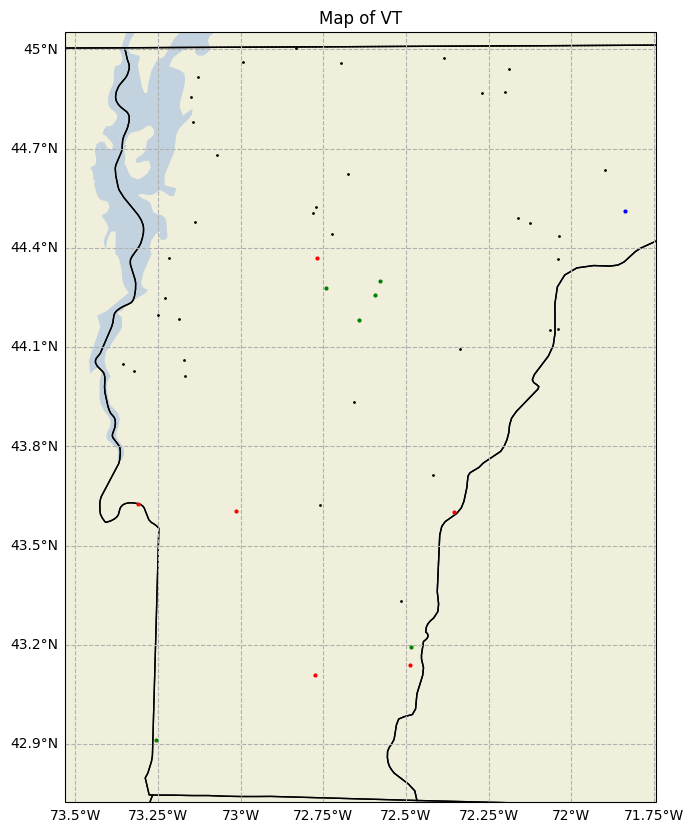

In [13]:
# Control Panel
# [114, 414, 410, 496, 60, 47, 476, 635, 484, 599, 55, 74, 644, 305, 376, 359, 280, 42, 278, 97, 657, 624, 623, 192, 136, 405, 397, 77, 619, 51, 497, 202, 525, 135, 440, 78, 99, 210, 590, 616, 177, 279, 667, 238, 1, 419, 626, 577, 386, 264, 266, 267, 185, 341, 371, 545, 356, 130, 648, 331, 536, 439, 350, 309, 39, 429, 271, 333, 14, 15, 610, 389, 390, 373, 622, 437, 438, 385, 22, 26, 637, 669, 272, 666, 11, 33, 28, 444, 25, 491, 493, 13, 16, 32, 360, 489, 518, 137, 579, 551, 654, 187, 12, 292, 67, 558, 299, 443, 409, 35, 487, 71, 10, 351, 312, 247, 552, 505, 614, 636, 607, 605, 34, 587, 483, 182, 284, 342, 561, 162, 490, 287, 596, 620, 101, 649, 514, 402, 455, 480, 150, 538, 277, 355, 76, 64, 470, 257, 417, 447, 383, 469, 662, 560, 629, 121, 41, 334, 68, 450, 392, 102, 479, 406, 571, 120, 562, 119, 5, 197, 152, 70, 124, 243, 265, 563, 363, 307, 573, 72, 582, 442, 19, 529, 404, 516, 73, 337, 138, 2, 3, 6, 52, 49, 255, 256, 344, 352, 20, 506, 606, 4, 377, 31, 485, 643, 196, 295, 30, 658, 583, 318, 195, 650, 511, 676, 94, 276, 375, 441, 145, 117, 345, 665, 21, 367, 190, 572, 65, 354, 18, 465, 300, 445, 680, 285, 395, 149, 274, 304, 655, 315, 329, 308, 659, 540, 365, 374, 100, 584, 388, 336, 594, 401, 24, 399, 40, 103, 403, 361, 368, 227, 231, 229, 234, 225, 220, 221, 651, 675, 521, 219, 222, 233, 498, 230, 347]
# list of good sites for NY (can be found through get_station_info)
# ['SiteCode = 01350000', 'SiteCode = 03011020', 'SiteCode = 01531000', 'SiteCode = 04231600', 'SiteCode = 01325000', 'SiteCode = 01315500', 'SiteCode = 04223000', 'SiteCode = 04266500', 'SiteCode = 04227500', 'SiteCode = 04252500', 'SiteCode = 01321000', 'SiteCode = 01334500', 'SiteCode = 04269000', 'SiteCode = 01426500', 'SiteCode = 01512500', 'SiteCode = 01503000', 'SiteCode = 01421000', 'SiteCode = 01315000', 'SiteCode = 01420500', 'SiteCode = 01346000', 'SiteCode = 04273500', 'SiteCode = 04263000', 'SiteCode = 04262500', 'SiteCode = 01367500', 'SiteCode = 01357500', 'SiteCode = 01529500', 'SiteCode = 01526500', 'SiteCode = 01335754', 'SiteCode = 04260500', 'SiteCode = 01318500', 'SiteCode = 04232000', 'SiteCode = 01371500', 'SiteCode = 04234000', 'SiteCode = 01357499', 'SiteCode = 04216000', 'SiteCode = 01336000', 'SiteCode = 01347000', 'SiteCode = 01372500', 'SiteCode = 04249000', 'SiteCode = 04258000', 'SiteCode = 01362500', 'SiteCode = 01420980', 'SiteCode = 04275500', 'SiteCode = 01375000', 'SiteCode = 01200000', 'SiteCode = 03014500', 'SiteCode = 04264331', 'SiteCode = 04242500', 'SiteCode = 01521500', 'SiteCode = 01413500', 'SiteCode = 01414500', 'SiteCode = 01415000', 'SiteCode = 01365000', 'SiteCode = 01437500', 'SiteCode = 01509000', 'SiteCode = 04235500', 'SiteCode = 01502500', 'SiteCode = 01351500', 'SiteCode = 04270000', 'SiteCode = 01435000', 'SiteCode = 04235000', 'SiteCode = 04215500', 'SiteCode = 01500000', 'SiteCode = 01428500', 'SiteCode = 01312000', 'SiteCode = 04213500', 'SiteCode = 01417000', 'SiteCode = 01436000', 'SiteCode = 01304500', 'SiteCode = 01305000', 'SiteCode = 04256000', 'SiteCode = 01523500', 'SiteCode = 01524500', 'SiteCode = 01510000', 'SiteCode = 04262000', 'SiteCode = 04214500', 'SiteCode = 04215000', 'SiteCode = 01520500', 'SiteCode = 01306500', 'SiteCode = 01308500', 'SiteCode = 04268000', 'SiteCode = 04276500', 'SiteCode = 01417500', 'SiteCode = 04275000', 'SiteCode = 01303000', 'SiteCode = 01310500', 'SiteCode = 01309500', 'SiteCode = 04217000', 'SiteCode = 01308000', 'SiteCode = 04230500', 'SiteCode = 04231000', 'SiteCode = 01304000', 'SiteCode = 01305500', 'SiteCode = 01310000', 'SiteCode = 01505000', 'SiteCode = 04229500', 'SiteCode = 04233000', 'SiteCode = 01358000', 'SiteCode = 04243500', 'SiteCode = 04237496', 'SiteCode = 04271500', 'SiteCode = 01365500', 'SiteCode = 01303500', 'SiteCode = 01423000', 'SiteCode = 01329490', 'SiteCode = 04239000', 'SiteCode = 01425000', 'SiteCode = 04216500', 'SiteCode = 01530500', 'SiteCode = 01311500', 'SiteCode = 04228500', 'SiteCode = 01330500', 'SiteCode = 01302500', 'SiteCode = 01500500', 'SiteCode = 01433500', 'SiteCode = 01376800', 'SiteCode = 04237500', 'SiteCode = 04232050', 'SiteCode = 04257000', 'SiteCode = 04267500', 'SiteCode = 04254500', 'SiteCode = 04253500', 'SiteCode = 01311000', 'SiteCode = 04246500', 'SiteCode = 04227000', 'SiteCode = 01364500', 'SiteCode = 01421900', 'SiteCode = 01496500', 'SiteCode = 04240100', 'SiteCode = 01362200', 'SiteCode = 04230380', 'SiteCode = 01422500', 'SiteCode = 04250750', 'SiteCode = 04261000', 'SiteCode = 01348000', 'SiteCode = 04270200', 'SiteCode = 04232482', 'SiteCode = 01528000', 'SiteCode = 04219000', 'SiteCode = 04225000', 'SiteCode = 01361000', 'SiteCode = 04235250', 'SiteCode = 01420000', 'SiteCode = 01502000', 'SiteCode = 01335500', 'SiteCode = 01327750', 'SiteCode = 04221500', 'SiteCode = 01387450', 'SiteCode = 03013000', 'SiteCode = 04218000', 'SiteCode = 01514000', 'SiteCode = 04221000', 'SiteCode = 04274000', 'SiteCode = 04240010', 'SiteCode = 04265000', 'SiteCode = 01350180', 'SiteCode = 01314000', 'SiteCode = 01436500', 'SiteCode = 01329500', 'SiteCode = 04218518', 'SiteCode = 01525500', 'SiteCode = 01349000', 'SiteCode = 04224775', 'SiteCode = 01529950', 'SiteCode = 04240180', 'SiteCode = 01350140', 'SiteCode = 04240105', 'SiteCode = 01350120', 'SiteCode = 01301500', 'SiteCode = 01370000', 'SiteCode = 01361500', 'SiteCode = 01330000', 'SiteCode = 01350355', 'SiteCode = 01376500', 'SiteCode = 01414000', 'SiteCode = 04240120', 'SiteCode = 01507000', 'SiteCode = 01427500', 'SiteCode = 04240300', 'SiteCode = 01331095', 'SiteCode = 04245000', 'SiteCode = 04216418', 'SiteCode = 01306460', 'SiteCode = 04234061', 'SiteCode = 01529000', 'SiteCode = 04232650', 'SiteCode = 01333500', 'SiteCode = 01437000', 'SiteCode = 01358500', 'SiteCode = 01300000', 'SiteCode = 01300500', 'SiteCode = 01302000', 'SiteCode = 01319000', 'SiteCode = 01317000', 'SiteCode = 01387400', 'SiteCode = 01387420', 'SiteCode = 01497500', 'SiteCode = 01501000', 'SiteCode = 01306495', 'SiteCode = 0423205010', 'SiteCode = 04254000', 'SiteCode = 01301000', 'SiteCode = 01513500', 'SiteCode = 01309990', 'SiteCode = 04227995', 'SiteCode = 04268800', 'SiteCode = 01369500', 'SiteCode = 0142400103', 'SiteCode = 01309950', 'SiteCode = 04273700', 'SiteCode = 04245200', 'SiteCode = 01434025', 'SiteCode = 01369000', 'SiteCode = 04270500', 'SiteCode = 04232100', 'SiteCode = 04279000', 'SiteCode = 01344000', 'SiteCode = 01419500', 'SiteCode = 01511500', 'SiteCode = 04216200', 'SiteCode = 01359750', 'SiteCode = 01350080', 'SiteCode = 01498500', 'SiteCode = 04274500', 'SiteCode = 01306499', 'SiteCode = 01508000', 'SiteCode = 01366500', 'SiteCode = 04240200', 'SiteCode = 01328000', 'SiteCode = 01501500', 'SiteCode = 01306440', 'SiteCode = 0422026250', 'SiteCode = 01425500', 'SiteCode = 04217500', 'SiteCode = 04280450', 'SiteCode = 01422000', 'SiteCode = 01526000', 'SiteCode = 01360640', 'SiteCode = 01418500', 'SiteCode = 01426000', 'SiteCode = 04271815', 'SiteCode = 01434017', 'SiteCode = 01434498', 'SiteCode = 01428000', 'SiteCode = 04273800', 'SiteCode = 04235271', 'SiteCode = 01507500', 'SiteCode = 01510500', 'SiteCode = 01347500', 'SiteCode = 04245236', 'SiteCode = 01522500', 'SiteCode = 01436690', 'SiteCode = 04250200', 'SiteCode = 01527500', 'SiteCode = 01307500', 'SiteCode = 01527000', 'SiteCode = 01313500', 'SiteCode = 01349150', 'SiteCode = 01528700', 'SiteCode = 01505500', 'SiteCode = 01508500', 'SiteCode = 01374701', 'SiteCode = 01374901', 'SiteCode = 01374821', 'SiteCode = 01374941', 'SiteCode = 0137462010', 'SiteCode = 01374505', 'SiteCode = 01374531', 'SiteCode = 04270510', 'SiteCode = 04278300', 'SiteCode = 04233300', 'SiteCode = 0137449480', 'SiteCode = 01374559', 'SiteCode = 01374930', 'SiteCode = 04232034', 'SiteCode = 01374890', 'SiteCode = 01499000']
import statistics as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

state = "NY"

# Year analysis begins
start_date = "1950"

# Year analysis ends
end_date = "2023"

# Specific date start ("01-01" for Jan 1 - Dec 31)
date = "01-01"

# Distance in weeks looked in each direction of date 
window_in_wks = 1 # 1 is 7 days

# determines which percentile is graphed, can be list of multiple percentiles
percentile = [2]

# determines how many days you look in each direction
scope = 7

# how many clusters to appear in each section
clusters = 2

# These constants are the top 10 events for each region, used in find_similarities
#streamflow
SF_BUFFALO = [['-56142.86, 1985/01/15 - 1985/01/29', '-35714.29, 1999/01/01 - 1999/01/15', '-32428.57, 2003/01/08 - 2003/01/22', '-32000.00, 2007/04/02 - 2007/04/16', '-31142.86, 2009/12/10 - 2009/12/24', '-30857.14, 2007/01/29 - 2007/02/12', '-29571.43, 1993/01/29 - 1993/02/12', '-29285.71, 1978/01/08 - 1978/01/22', '-29142.86, 1997/01/08 - 1997/01/22', '-28857.14, 1968/01/01 - 1968/01/15', '-2272.33, 1956/03/05 - 1956/03/19', '-2083.50, 1956/03/05 - 1956/03/19', '-1883.14, 1957/01/22 - 1957/02/05', '-1729.14, 1985/02/19 - 1985/03/05', '-1736.14, 2002/01/29 - 2002/02/12', '-1710.43, 1985/02/19 - 1985/03/05', '-1701.71, 1998/01/08 - 1998/01/22', '-1693.57, 2013/12/17 - 2013/12/31', '-1638.14, 2009/03/05 - 2009/03/19', '-1608.57, 1957/01/22 - 1957/02/05'], ['-69428.57, 1985/01/15 - 1985/02/05', '-45428.57, 1985/01/08 - 1985/01/29', '-33714.29, 2008/01/15 - 2008/02/05', '-32714.29, 2007/01/29 - 2007/02/19', '-32571.43, 2015/01/01 - 2015/01/22', '-31142.86, 1974/11/12 - 1974/12/03', '-29500.00, 1976/12/10 - 1976/12/31', '-29000.00, 2007/01/22 - 2007/02/12', '-27714.29, 1997/01/08 - 1997/01/29', '-27000.00, 1993/01/22 - 1993/02/12', '-2442.83, 1956/03/05 - 1956/03/26', '-2269.50, 1956/03/05 - 1956/03/26', '-1854.71, 1993/03/26 - 1993/04/16', '-1812.00, 2002/01/29 - 2002/02/19', '-1775.13, 2004/05/21 - 2004/06/11', '-1733.00, 2005/04/02 - 2005/04/23', '-1697.14, 1981/02/19 - 1981/03/12', '-1686.29, 1993/03/26 - 1993/04/16', '-1682.57, 2009/03/05 - 2009/03/26', '-1677.33, 1960/03/26 - 1960/04/16'], ['-58714.29, 1985/01/08 - 1985/02/05', '-58714.29, 1985/01/15 - 1985/02/12', '-42000.00, 1985/01/01 - 1985/01/29', '-40285.71, 2015/01/01 - 2015/01/29', '-37000.00, 1963/01/08 - 1963/02/05', '-35142.86, 1997/01/08 - 1997/02/05', '-34000.00, 2007/01/15 - 2007/02/12', '-31285.71, 1980/01/08 - 1980/02/05', '-30857.14, 2007/01/22 - 2007/02/19', '-27571.43, 2008/01/08 - 2008/02/05', '-2114.17, 1956/03/05 - 1956/04/02', '-1983.00, 1956/03/05 - 1956/04/02', '-1944.86, 1957/01/22 - 1957/02/19', '-1911.57, 1993/03/26 - 1993/04/23', '-1815.63, 2004/05/21 - 2004/06/18', '-1777.86, 2009/03/05 - 2009/04/02', '-1776.86, 1993/03/26 - 1993/04/23', '-1701.43, 2007/03/12 - 2007/04/09', '-1668.86, 1957/01/22 - 1957/02/19', '-1668.00, 1950/03/26 - 1950/04/23'], ['-55285.71, 1985/01/01 - 1985/02/05', '-48000.00, 1985/01/08 - 1985/02/12', '-47142.86, 1985/01/15 - 1985/02/19', '-38571.43, 2021/01/15 - 2021/02/19', '-36142.86, 2015/01/01 - 2015/02/05', '-35857.14, 2007/01/15 - 2007/02/19', '-35500.00, 1976/11/26 - 1976/12/31', '-31857.14, 2007/01/08 - 2007/02/12', '-31571.43, 1993/01/29 - 1993/03/05', '-31142.86, 1964/01/01 - 1964/02/05', '-1963.14, 1993/03/26 - 1993/04/30', '-1885.43, 1957/01/22 - 1957/02/26', '-1849.71, 1993/03/26 - 1993/04/30', '-1821.33, 1960/03/26 - 1960/04/30', '-1789.00, 1985/02/19 - 1985/03/26', '-1781.86, 1977/09/17 - 1977/10/22', '-1781.57, 1998/01/08 - 1998/02/12', '-1759.30, 2004/05/21 - 2004/06/25', '-1721.86, 1950/03/26 - 1950/04/30', '-1701.86, 2005/04/02 - 2005/05/07']]
SF_ADIRONDACKS = [['-9538.57, 1998/01/08 - 1998/01/22', '-8091.43, 1953/03/26 - 1953/04/09', '-7072.86, 2011/04/23 - 2011/05/07', '-6771.43, 2019/10/29 - 2019/11/12', '-6430.00, 1981/02/19 - 1981/03/05', '-5948.57, 2001/04/23 - 2001/05/07', '-5936.67, 1972/04/30 - 1972/05/14', '-5411.43, 2007/04/23 - 2007/05/07', '-5351.43, 1977/04/23 - 1977/05/07', '-5308.57, 1983/04/30 - 1983/05/14', '-2162.00, 1953/03/26 - 1953/04/09', '-1887.86, 2019/10/29 - 2019/11/12', '-1615.71, 2011/04/23 - 2011/05/07', '-1609.00, 2014/04/16 - 2014/04/30', '-1607.57, 2011/04/30 - 2011/05/14', '-1599.17, 1976/04/02 - 1976/04/16', '-1563.86, 1983/04/30 - 1983/05/14', '-1543.43, 2007/04/23 - 2007/05/07', '-1515.50, 2012/03/19 - 2012/04/02', '-1500.57, 2021/03/26 - 2021/04/09'], ['-12330.00, 2011/04/23 - 2011/05/14', '-10240.00, 1998/01/08 - 1998/01/29', '-8618.57, 1981/02/19 - 1981/03/12', '-8580.00, 1953/03/26 - 1953/04/16', '-8521.43, 2001/04/23 - 2001/05/14', '-8141.43, 2019/10/29 - 2019/11/19', '-8090.00, 1952/04/16 - 1952/05/07', '-7540.00, 1979/04/23 - 1979/05/14', '-7461.43, 2007/04/23 - 2007/05/14', '-7455.00, 1960/04/16 - 1960/05/07', '-3223.29, 2011/04/23 - 2011/05/14', '-2679.57, 2019/04/16 - 2019/05/07', '-2474.71, 1953/03/26 - 1953/04/16', '-2277.00, 2019/10/29 - 2019/11/19', '-2050.50, 1960/04/16 - 1960/05/07', '-2043.29, 1955/04/16 - 1955/05/07', '-2021.14, 1981/02/19 - 1981/03/12', '-1994.43, 2018/04/30 - 2018/05/21', '-1963.29, 1983/04/30 - 1983/05/21', '-1921.43, 1954/04/16 - 1954/05/07'], ['-11684.29, 2011/04/23 - 2011/05/21', '-10442.86, 1998/01/08 - 1998/02/05', '-9708.33, 1972/04/30 - 1972/05/28', '-9427.14, 1953/03/26 - 1953/04/23', '-9205.57, 2001/04/23 - 2001/05/21', '-9013.33, 1960/04/16 - 1960/05/14', '-8981.71, 1981/02/19 - 1981/03/19', '-8920.67, 1952/04/16 - 1952/05/14', '-8531.43, 1979/04/23 - 1979/05/21', '-8117.14, 2019/10/29 - 2019/11/26', '-2869.71, 2011/04/23 - 2011/05/21', '-2852.43, 1953/03/26 - 1953/04/23', '-2523.57, 2019/04/16 - 2019/05/14', '-2486.14, 1955/04/16 - 1955/05/14', '-2296.71, 2019/10/29 - 2019/11/26', '-2295.83, 1960/04/16 - 1960/05/14', '-2254.43, 1979/04/23 - 1979/05/21', '-2184.71, 1954/04/16 - 1954/05/14', '-2173.17, 1952/04/16 - 1952/05/14', '-2167.83, 1972/04/30 - 1972/05/28'], ['-12295.71, 2011/04/23 - 2011/05/28', '-10983.33, 1972/04/30 - 1972/06/04', '-10610.57, 1998/01/08 - 1998/02/12', '-9390.86, 1981/02/19 - 1981/03/26', '-9181.14, 1993/04/16 - 1993/05/21', '-8922.71, 1971/05/07 - 1971/06/11', '-8791.29, 2001/04/23 - 2001/05/28', '-8741.43, 2007/04/23 - 2007/05/28', '-8466.67, 2008/04/09 - 2008/05/14', '-8408.57, 1979/04/23 - 1979/05/28', '-3212.57, 2011/04/23 - 2011/05/28', '-2728.86, 1955/04/16 - 1955/05/21', '-2727.14, 2019/04/16 - 2019/05/21', '-2717.00, 1954/04/16 - 1954/05/21', '-2614.33, 1972/04/30 - 1972/06/04', '-2404.43, 1979/04/23 - 1979/05/28', '-2390.67, 2008/04/16 - 2008/05/21', '-2384.86, 1971/05/07 - 1971/06/11', '-2348.29, 2018/04/30 - 2018/06/04', '-2324.86, 2007/04/23 - 2007/05/28']]
SF_CATSKILLS = [['-7990.29, 1955/10/15 - 1955/10/29', '-6245.14, 2005/04/02 - 2005/04/16', '-6276.25, 1996/01/15 - 1996/01/29', '-5230.00, 1987/04/02 - 1987/04/16', '-4830.00, 2007/04/16 - 2007/04/30', '-4788.33, 2008/03/05 - 2008/03/19', '-4634.29, 2001/04/09 - 2001/04/23', '-4388.14, 2005/04/02 - 2005/04/16', '-4167.83, 1980/03/19 - 1980/04/02', '-4259.57, 2011/08/27 - 2011/09/10', '-4217.43, 2011/09/03 - 2011/09/17', '-3992.86, 1987/04/02 - 1987/04/16', '-4619.57, 2005/04/02 - 2005/04/16', '-3908.17, 1984/05/28 - 1984/06/11', '-4520.00, 2008/03/05 - 2008/03/19', '-3723.17, 2008/03/05 - 2008/03/19', '-3719.57, 2010/10/01 - 2010/10/15', '-3878.00, 1977/03/12 - 1977/03/26', '-3838.33, 1980/03/19 - 1980/04/02', '-3635.33, 1984/04/02 - 1984/04/16'], ['-8477.00, 2011/08/27 - 2011/09/17', '-9171.11, 1996/01/15 - 1996/02/05', '-7252.86, 1987/04/02 - 1987/04/23', '-6369.57, 2011/08/27 - 2011/09/17', '-6314.43, 1955/10/15 - 1955/11/05', '-6696.29, 2005/04/02 - 2005/04/23', '-6258.43, 2007/04/16 - 2007/05/07', '-5370.14, 1987/04/02 - 1987/04/23', '-6626.29, 2011/08/27 - 2011/09/17', '-5373.57, 2001/04/09 - 2001/04/30', '-5096.57, 1983/04/23 - 1983/05/14', '-5096.14, 2011/09/03 - 2011/09/24', '-4735.00, 2005/04/02 - 2005/04/23', '-4729.43, 1958/04/16 - 1958/05/07', '-5927.14, 1987/04/02 - 1987/04/23', '-5807.29, 2007/04/16 - 2007/05/07', '-4593.00, 2007/04/16 - 2007/05/07', '-4493.50, 1980/03/19 - 1980/04/09', '-5331.33, 1996/07/09 - 1996/07/30', '-4480.28, 1984/05/28 - 1984/06/18'], ['-9355.71, 2011/08/27 - 2011/09/24', '-9995.68, 1996/01/15 - 1996/02/12', '-8248.00, 1987/04/02 - 1987/04/30', '-7595.71, 1955/10/15 - 1955/11/12', '-7005.57, 2011/08/27 - 2011/09/24', '-6279.14, 1987/04/02 - 1987/04/30', '-6632.13, 2007/04/16 - 2007/05/14', '-6409.57, 2010/03/19 - 2010/04/16', '-6317.86, 2001/04/09 - 2001/05/07', '-7331.14, 2011/08/27 - 2011/09/24', '-6979.14, 1987/04/02 - 1987/04/30', '-5870.00, 2005/04/02 - 2005/04/30', '-5102.43, 1958/04/16 - 1958/05/14', '-5425.00, 1983/04/23 - 1983/05/21', '-6238.39, 2007/04/16 - 2007/05/14', '-5181.83, 2008/03/05 - 2008/04/02', '-4757.57, 2007/04/16 - 2007/05/14', '-4675.43, 2010/03/19 - 2010/04/16', '-4555.71, 1996/01/15 - 1996/02/12', '-5782.43, 2001/04/09 - 2001/05/07'], ['-10259.68, 1996/01/15 - 1996/02/19', '-8532.57, 1987/04/02 - 1987/05/07', '-7577.43, 1955/10/15 - 1955/11/19', '-7881.14, 2011/08/27 - 2011/10/01', '-6485.71, 1987/04/02 - 1987/05/07', '-7022.86, 2010/03/19 - 2010/04/23', '-6759.43, 2007/04/16 - 2007/05/21', '-6558.49, 2001/04/09 - 2001/05/14', '-6541.86, 2005/04/02 - 2005/05/07', '-7304.00, 1987/04/02 - 1987/05/07', '-5814.00, 1996/01/15 - 1996/02/19', '-5293.57, 2010/03/19 - 2010/04/23', '-6610.86, 2010/03/19 - 2010/04/23', '-5119.57, 1958/04/16 - 1958/05/21', '-6487.57, 2007/04/16 - 2007/05/21', '-5084.86, 2011/08/27 - 2011/10/01', '-5506.43, 1983/04/23 - 1983/05/28', '-4805.00, 2007/04/16 - 2007/05/21', '-5935.43, 2011/08/27 - 2011/10/01', '-4635.71, 1996/01/15 - 1996/02/19']]
SF_LONG_ISLAND = [['-109.93, 2005/10/08 - 2005/10/22', '-76.77, 2014/04/30 - 2014/05/14', '-73.76, 2010/03/26 - 2010/04/09', '-65.82, 2014/08/13 - 2014/08/27', '-61.67, 1960/09/10 - 1960/09/24', '-54.60, 1976/08/06 - 1976/08/20', '-52.26, 1955/08/13 - 1955/08/27', '-48.29, 1978/01/22 - 1978/02/05', '-44.53, 1984/05/28 - 1984/06/11', '-43.17, 1980/04/09 - 1980/04/23', '-34.42, 2005/10/08 - 2005/10/22', '-27.41, 1998/06/11 - 1998/06/25', '-26.00, 1980/04/09 - 1980/04/23', '-25.71, 1978/01/22 - 1978/02/05', '-23.07, 1955/08/13 - 1955/08/27', '-22.41, 1990/08/20 - 1990/09/03', '-22.40, 1976/08/06 - 1976/08/20', '-21.67, 1960/09/10 - 1960/09/24', '-20.83, 1984/05/28 - 1984/06/11', '-20.00, 1980/04/09 - 1980/04/23'], ['-115.02, 2005/10/08 - 2005/10/29', '-75.31, 2010/03/26 - 2010/04/16', '-73.47, 2014/04/30 - 2014/05/21', '-73.00, 1960/09/10 - 1960/10/01', '-72.09, 2013/06/04 - 2013/06/25', '-67.36, 2014/08/13 - 2014/09/03', '-60.87, 1976/08/06 - 1976/08/27', '-56.24, 1955/08/13 - 1955/09/03', '-51.71, 1978/01/22 - 1978/02/12', '-48.79, 2014/12/03 - 2014/12/24', '-37.32, 2005/10/08 - 2005/10/29', '-29.71, 1998/06/11 - 1998/07/02', '-29.55, 1952/05/28 - 1952/06/18', '-28.86, 1978/01/22 - 1978/02/12', '-28.14, 1979/01/22 - 1979/02/12', '-27.97, 1955/08/13 - 1955/09/03', '-27.67, 1984/05/28 - 1984/06/18', '-27.17, 1960/09/10 - 1960/10/01', '-26.33, 1976/08/06 - 1976/08/27', '-25.27, 1990/08/20 - 1990/09/10'], ['-124.50, 2005/10/08 - 2005/11/05', '-80.05, 2014/04/30 - 2014/05/28', '-78.16, 2010/03/26 - 2010/04/23', '-73.67, 1960/09/10 - 1960/10/08', '-67.98, 2014/08/13 - 2014/09/10', '-66.23, 2013/06/04 - 2013/07/02', '-62.02, 1976/08/06 - 1976/09/03', '-60.19, 1955/08/13 - 1955/09/10', '-53.57, 1978/01/22 - 1978/02/19', '-47.52, 1984/05/28 - 1984/06/25', '-43.74, 2005/10/08 - 2005/11/05', '-34.86, 1978/01/22 - 1978/02/19', '-34.29, 1979/01/22 - 1979/02/19', '-33.16, 1998/06/11 - 1998/07/09', '-30.97, 1952/05/28 - 1952/06/25', '-30.67, 1984/05/28 - 1984/06/25', '-30.17, 1955/08/13 - 1955/09/10', '-29.17, 1960/09/10 - 1960/10/08', '-28.29, 1979/01/15 - 1979/02/12', '-27.33, 1980/04/09 - 1980/05/07'], ['-124.95, 2005/10/08 - 2005/11/12', '-85.48, 2014/04/30 - 2014/06/04', '-77.17, 1960/09/10 - 1960/10/15', '-67.79, 2014/08/13 - 2014/09/17', '-65.74, 2013/06/04 - 2013/07/09', '-62.08, 1976/08/06 - 1976/09/10', '-61.29, 2010/03/26 - 2010/04/30', '-58.43, 1955/08/13 - 1955/09/17', '-55.00, 1978/01/22 - 1978/02/26', '-46.03, 2014/03/26 - 2014/04/30', '-43.69, 2005/10/08 - 2005/11/12', '-37.57, 1978/01/22 - 1978/02/26', '-35.80, 1998/06/11 - 1998/07/16', '-34.43, 1979/01/15 - 1979/02/19', '-33.05, 1952/05/28 - 1952/07/02', '-30.33, 1960/09/10 - 1960/10/15', '-30.39, 1955/08/13 - 1955/09/17', '-26.83, 1980/04/09 - 1980/05/14', '-26.14, 1979/01/22 - 1979/02/26', '-26.12, 1976/08/06 - 1976/09/10']]
#evaporation
EV_BUFFALO = [['-1.59, 2001/04/22 - 2001/05/06', '-1.45, 1984/06/03 - 1984/06/17', '-1.31, 2015/07/22 - 2015/08/05', '-1.25, 2015/04/08 - 2015/04/22', '-1.19, 1990/04/22 - 1990/05/06', '-1.18, 2008/04/15 - 2008/04/29', '-1.18, 2003/08/12 - 2003/08/26', '-1.09, 2007/04/29 - 2007/05/13', '-1.08, 2020/05/20 - 2020/06/03', '-1.07, 2006/06/10 - 2006/06/24'], ['-2.33, 2001/04/15 - 2001/05/06', '-2.25, 1984/05/27 - 1984/06/17', '-1.94, 2001/04/22 - 2001/05/13', '-1.94, 2007/04/29 - 2007/05/20', '-1.86, 1990/04/15 - 1990/05/06', '-1.77, 2016/05/20 - 2016/06/10', '-1.75, 2005/04/01 - 2005/04/22', '-1.75, 1984/06/03 - 1984/06/24', '-1.74, 2008/04/08 - 2008/04/29', '-1.71, 2018/04/29 - 2018/05/20'], ['-2.69, 2001/04/08 - 2001/05/06', '-2.68, 2001/04/15 - 2001/05/13', '-2.55, 1984/05/27 - 1984/06/24', '-2.52, 2008/04/01 - 2008/04/29', '-2.41, 2020/05/20 - 2020/06/17', '-2.25, 2018/04/22 - 2018/05/20', '-2.16, 2018/04/29 - 2018/05/27', '-2.12, 2003/06/17 - 2003/07/15', '-2.10, 2016/05/20 - 2016/06/17', '-2.09, 2001/04/01 - 2001/04/29'], ['-3.68, 2001/04/01 - 2001/05/06', '-3.04, 2001/04/08 - 2001/05/13', '-2.84, 2020/05/13 - 2020/06/17', '-2.81, 2020/05/20 - 2020/06/24', '-2.76, 2021/05/06 - 2021/06/10', '-2.69, 2018/04/22 - 2018/05/27', '-2.63, 1984/05/27 - 1984/07/01', '-2.63, 2018/04/29 - 2018/06/03', '-2.62, 1983/06/03 - 1983/07/08', '-2.57, 2008/04/01 - 2008/05/06']]
EV_ADIRONDACKS = [['-1.52, 2001/04/22 - 2001/05/06', '-1.39, 2003/06/17 - 2003/07/01', '-1.35, 1984/06/03 - 1984/06/17', '-1.32, 2015/04/08 - 2015/04/22', '-1.32, 2015/04/29 - 2015/05/13', '-1.28, 2005/06/17 - 2005/07/01', '-1.26, 1988/06/10 - 1988/06/24', '-1.25, 2007/05/06 - 2007/05/20', '-1.23, 2011/07/15 - 2011/07/29', '-1.19, 2018/05/06 - 2018/05/20'], ['-2.32, 2001/04/15 - 2001/05/06', '-2.29, 2007/04/29 - 2007/05/20', '-2.18, 2003/06/17 - 2003/07/08', '-2.09, 2018/04/29 - 2018/05/20', '-1.91, 1984/05/27 - 1984/06/17', '-1.86, 2001/04/22 - 2001/05/13', '-1.83, 1991/05/06 - 1991/05/27', '-1.81, 2001/07/29 - 2001/08/19', '-1.81, 2008/04/08 - 2008/04/29', '-1.81, 2018/05/06 - 2018/05/27'], ['-2.97, 2001/04/08 - 2001/05/06', '-2.71, 2018/04/29 - 2018/05/27', '-2.67, 1983/06/03 - 1983/07/01', '-2.66, 2001/04/15 - 2001/05/13', '-2.50, 2003/06/17 - 2003/07/15', '-2.44, 2018/05/06 - 2018/06/03', '-2.44, 1983/06/10 - 1983/07/08', '-2.26, 2002/06/24 - 2002/07/22', '-2.24, 1995/06/03 - 1995/07/01', '-2.17, 2008/04/01 - 2008/04/29'], ['-3.45, 1983/06/03 - 1983/07/08', '-3.41, 2001/04/01 - 2001/05/06', '-3.35, 2018/04/29 - 2018/06/03', '-3.31, 2001/04/08 - 2001/05/13', '-2.95, 2015/04/08 - 2015/05/13', '-2.86, 2003/06/17 - 2003/07/22', '-2.82, 2007/04/15 - 2007/05/20', '-2.75, 2018/04/22 - 2018/05/27', '-2.67, 2021/05/06 - 2021/06/10', '-2.66, 2001/04/15 - 2001/05/20']]
EV_CATSKILLS = [['-1.61, 2001/04/22 - 2001/05/06', '-1.48, 2015/07/22 - 2015/08/05', '-1.43, 2016/05/20 - 2016/06/03', '-1.38, 1984/06/03 - 1984/06/17', '-1.29, 1988/06/10 - 1988/06/24', '-1.27, 2015/04/08 - 2015/04/22', '-1.23, 2016/05/27 - 2016/06/10', '-1.22, 2017/04/08 - 2017/04/22', '-1.17, 2007/05/06 - 2007/05/20', '-1.14, 2001/04/15 - 2001/04/29'], ['-2.75, 2001/04/15 - 2001/05/06', '-2.65, 2016/05/20 - 2016/06/10', '-2.11, 2001/04/08 - 2001/04/29', '-2.08, 2007/04/29 - 2007/05/20', '-2.07, 2015/07/22 - 2015/08/12', '-2.01, 2005/04/01 - 2005/04/22', '-1.98, 2001/04/22 - 2001/05/13', '-1.87, 2021/05/06 - 2021/05/27', '-1.81, 1991/05/06 - 1991/05/27', '-1.79, 1984/05/27 - 1984/06/17'], ['-3.72, 2001/04/08 - 2001/05/06', '-3.11, 2001/04/15 - 2001/05/13', '-2.78, 2016/05/20 - 2016/06/17', '-2.43, 2005/04/01 - 2005/04/29', '-2.22, 1998/05/13 - 1998/06/10', '-2.21, 2001/04/01 - 2001/04/29', '-2.20, 2002/06/24 - 2002/07/22', '-2.19, 1983/06/03 - 1983/07/01', '-2.18, 1983/06/10 - 1983/07/08', '-2.18, 2001/06/10 - 2001/07/08'], ['-4.08, 2001/04/08 - 2001/05/13', '-3.82, 2001/04/01 - 2001/05/06', '-3.21, 2016/05/20 - 2016/06/24', '-3.11, 2001/04/15 - 2001/05/20', '-2.88, 1988/05/20 - 1988/06/24', '-2.84, 1983/06/03 - 1983/07/08', '-2.70, 1982/04/08 - 1982/05/13', '-2.66, 2007/04/29 - 2007/06/03', '-2.64, 2015/04/08 - 2015/05/13', '-2.54, 2020/05/13 - 2020/06/17']]
EV_LONG_ISLAND = [['-1.67, 2001/04/22 - 2001/05/06', '-1.50, 1980/05/20 - 1980/06/03', '-1.35, 1999/05/27 - 1999/06/10', '-1.35, 2021/05/06 - 2021/05/20', '-1.34, 1992/05/13 - 1992/05/27', '-1.28, 1998/05/27 - 1998/06/10', '-1.19, 2006/09/16 - 2006/09/30', '-1.13, 1991/05/13 - 1991/05/27', '-1.12, 1995/08/12 - 1995/08/26', '-1.10, 1988/05/27 - 1988/06/10'], ['-2.44, 2001/04/22 - 2001/05/13', '-2.26, 2001/04/15 - 2001/05/06', '-2.17, 1998/05/20 - 1998/06/10', '-2.15, 2021/05/06 - 2021/05/27', '-1.98, 1991/05/06 - 1991/05/27', '-1.95, 1988/05/20 - 1988/06/10', '-1.77, 1988/05/27 - 1988/06/17', '-1.73, 1998/05/13 - 1998/06/03', '-1.69, 1997/09/09 - 1997/09/30', '-1.60, 1991/05/13 - 1991/06/03'], ['-3.04, 2001/04/15 - 2001/05/13', '-3.01, 1998/05/13 - 1998/06/10', '-2.67, 1988/05/27 - 1988/06/24', '-2.62, 1988/05/20 - 1988/06/17', '-2.56, 2001/04/22 - 2001/05/20', '-2.44, 1991/05/06 - 1991/06/03', '-2.24, 1993/04/15 - 1993/05/13', '-2.23, 1993/04/22 - 1993/05/20', '-2.21, 2001/04/08 - 2001/05/06', '-2.14, 1998/05/20 - 1998/06/17'], ['-3.52, 1988/05/20 - 1988/06/24', '-3.15, 2001/04/15 - 2001/05/20', '-2.98, 2001/04/08 - 2001/05/13', '-2.97, 1998/05/13 - 1998/06/17', '-2.96, 1988/05/27 - 1988/07/01', '-2.94, 1993/04/15 - 1993/05/20', '-2.75, 1998/05/06 - 1998/06/10', '-2.52, 1991/05/06 - 1991/06/10', '-2.48, 1995/07/22 - 1995/08/26', '-2.36, 1993/04/22 - 1993/05/27']]
# precipitation
PC_BUFFALO = [['-5.290, 1985/11/26 - 1985/12/10', '-4.420, 1979/09/17 - 1979/10/01', '-4.290, 2004/09/30 - 2004/10/14', '-4.100, 1977/10/08 - 1977/10/22', '-3.990, 1979/10/01 - 1979/10/15', '-3.830, 2005/07/02 - 2005/07/16', '-3.720, 1998/01/29 - 1998/02/12', '-3.690, 2012/11/18 - 2012/12/02', '-3.630, 2017/11/19 - 2017/12/03', '-3.610, 1959/10/22 - 1959/11/05'],['-7.970, 1977/10/01 - 1977/10/29', '-7.810, 1977/10/08 - 1977/11/05', '-7.700, 1979/09/17 - 1979/10/15', '-6.600, 1963/08/20 - 1963/09/17', '-6.220, 2004/09/16 - 2004/10/14', '-5.980, 1984/07/01 - 1984/07/29', '-5.940, 2017/11/12 - 2017/12/10', '-5.740, 1984/07/08 - 1984/08/05', '-5.710, 2012/11/04 - 2012/12/02', '-5.340, 1985/11/19 - 1985/12/17'],['-7.970, 1977/10/01 - 1977/10/29', '-7.810, 1977/10/08 - 1977/11/05', '-7.700, 1979/09/17 - 1979/10/15', '-6.600, 1963/08/20 - 1963/09/17', '-6.220, 2004/09/16 - 2004/10/14', '-5.980, 1984/07/01 - 1984/07/29', '-5.940, 2017/11/12 - 2017/12/10', '-5.740, 1984/07/08 - 1984/08/05', '-5.710, 2012/11/04 - 2012/12/02', '-5.340, 1985/11/19 - 1985/12/17'],['-8.360, 1977/10/01 - 1977/11/05', '-8.340, 1979/09/10 - 1979/10/15', '-7.640, 1977/09/24 - 1977/10/29', '-7.190, 1979/09/17 - 1979/10/22', '-7.010, 2012/10/28 - 2012/12/02', '-6.940, 1977/10/08 - 1977/11/12', '-6.590, 1963/08/13 - 1963/09/17', '-6.340, 1963/08/20 - 1963/09/24', '-6.110, 1984/07/01 - 1984/08/05', '-6.090, 1989/06/18 - 1989/07/23']]
PC_ADIRONDACKS = [['-4.730, 1999/10/08 - 1999/10/22', '-3.630, 2008/08/12 - 2008/08/26', '-3.540, 2019/11/19 - 2019/12/03', '-3.500, 1964/09/09 - 1964/09/23', '-3.310, 2011/03/26 - 2011/04/09', '-3.240, 1996/11/25 - 1996/12/09', '-3.230, 1995/11/12 - 1995/11/26', '-3.210, 1998/07/02 - 1998/07/16', '-3.200, 1998/01/29 - 1998/02/12', '-3.120, 2004/06/10 - 2004/06/24'],['-5.250, 2011/09/17 - 2011/10/08', '-4.720, 1987/10/01 - 1987/10/22', '-4.710, 2019/11/12 - 2019/12/03', '-4.640, 1964/09/02 - 1964/09/23', '-4.620, 2011/03/19 - 2011/04/09', '-4.540, 2015/07/02 - 2015/07/23', '-4.540, 1999/10/08 - 1999/10/29', '-4.530, 1995/11/12 - 1995/12/03', '-4.350, 1995/11/05 - 1995/11/26', '-4.280, 1983/12/24 - 1984/01/14'],['-7.130, 2019/11/05 - 2019/12/03', '-6.060, 1999/10/08 - 1999/11/05', '-5.830, 2008/08/12 - 2008/09/09', '-5.700, 2015/07/02 - 2015/07/30', '-5.650, 1995/11/05 - 1995/12/03', '-5.560, 2015/06/25 - 2015/07/23', '-5.460, 1998/07/02 - 1998/07/30', '-5.400, 2011/03/19 - 2011/04/16', '-5.370, 1983/12/17 - 1984/01/14', '-5.280, 1978/01/29 - 1978/02/26'],['-7.660, 2019/10/29 - 2019/12/03', '-7.040, 2015/06/18 - 2015/07/23', '-6.780, 2019/11/05 - 2019/12/10', '-6.720, 2015/06/25 - 2015/07/30', '-6.430, 1998/07/02 - 1998/08/06', '-6.360, 2008/08/05 - 2008/09/09', '-6.350, 1999/10/08 - 1999/11/12', '-6.020, 2011/09/03 - 2011/10/08', '-6.010, 2015/07/02 - 2015/08/06', '-5.820, 1995/11/12 - 1995/12/17']]
PC_CATSKILLS = [['-6.610, 1960/09/30 - 1960/10/14', '-6.510, 1999/10/08 - 1999/10/22', '-6.110, 1955/11/05 - 1955/11/19', '-5.760, 2008/08/12 - 2008/08/26', '-5.640, 2005/11/05 - 2005/11/19', '-5.240, 1955/09/03 - 1955/09/17', '-5.160, 2010/10/22 - 2010/11/05', '-5.060, 2011/09/24 - 2011/10/08', '-5.000, 2021/07/30 - 2021/08/13', '-4.790, 2011/09/17 - 2011/10/01'],['-9.850, 2011/09/17 - 2011/10/08', '-9.470, 2005/10/29 - 2005/11/19', '-8.680, 2005/11/05 - 2005/11/26', '-8.190, 1955/09/03 - 1955/09/24', '-7.730, 1960/09/30 - 1960/10/21', '-6.880, 2008/08/05 - 2008/08/26', '-6.870, 2018/08/13 - 2018/09/03', '-6.700, 1955/10/29 - 1955/11/19', '-6.410, 1955/11/05 - 1955/11/26', '-6.350, 1999/10/01 - 1999/10/22'],['-12.510, 2005/10/29 - 2005/11/26', '-9.830, 2011/09/10 - 2011/10/08', '-9.560, 2005/10/22 - 2005/11/19', '-8.580, 2011/09/17 - 2011/10/15', '-8.480, 1955/08/27 - 1955/09/24', '-8.050, 1955/09/03 - 1955/10/01', '-7.620, 1955/11/05 - 1955/12/03', '-7.460, 1960/09/23 - 1960/10/21', '-7.390, 2018/08/13 - 2018/09/10', '-7.310, 2005/11/05 - 2005/12/03'],['-12.600, 2005/10/22 - 2005/11/26', '-11.920, 2011/09/03 - 2011/10/08', '-11.140, 2005/10/29 - 2005/12/03', '-9.330, 2018/08/13 - 2018/09/17', '-8.560, 2011/09/10 - 2011/10/15', '-8.340, 1955/08/27 - 1955/10/01', '-8.210, 1955/10/29 - 1955/12/03', '-8.180, 2011/09/17 - 2011/10/22', '-7.830, 1955/11/05 - 1955/12/10', '-7.800, 2005/11/05 - 2005/12/10']]
PC_LONG_ISLAND = [['-9.060, 1955/09/03 - 1955/09/17', '-7.890, 2005/10/29 - 2005/11/12', '-7.370, 1960/09/30 - 1960/10/14', '-7.020, 2014/09/03 - 2014/09/17', '-6.460, 2005/11/05 - 2005/11/19', '-6.280, 1976/08/26 - 1976/09/09', '-6.050, 2013/06/25 - 2013/07/09', '-6.030, 2011/09/03 - 2011/09/17', '-5.890, 1975/10/15 - 1975/10/29', '-5.270, 1954/10/01 - 1954/10/15'],['-14.350, 2005/10/29 - 2005/11/19', '-11.280, 1955/08/27 - 1955/09/17', '-9.340, 1955/09/03 - 1955/09/24', '-8.840, 2013/06/25 - 2013/07/16', '-8.610, 2003/06/18 - 2003/07/09', '-7.920, 2005/10/22 - 2005/11/12', '-7.490, 1960/09/23 - 1960/10/14', '-7.450, 2005/11/05 - 2005/11/26', '-6.910, 2014/08/27 - 2014/09/17', '-6.710, 1976/08/26 - 1976/09/16'],['-15.340, 2005/10/29 - 2005/11/26', '-14.380, 2005/10/22 - 2005/11/19', '-11.560, 1955/08/27 - 1955/09/24', '-11.170, 1955/08/20 - 1955/09/17', '-10.880, 2011/09/03 - 2011/10/01', '-9.990, 2003/06/18 - 2003/07/16', '-8.760, 2013/06/18 - 2013/07/16', '-8.670, 2013/06/25 - 2013/07/23', '-8.040, 2003/06/11 - 2003/07/09', '-7.750, 1955/09/03 - 1955/10/01'],['-15.370, 2005/10/22 - 2005/11/26', '-14.300, 2005/10/29 - 2005/12/03', '-12.650, 2011/09/03 - 2011/10/08', '-12.610, 2005/10/15 - 2005/11/19', '-11.750, 2003/06/18 - 2003/07/23', '-11.450, 1955/08/20 - 1955/09/24', '-10.980, 1955/08/13 - 1955/09/17', '-10.160, 2013/06/11 - 2013/07/16', '-9.970, 1955/08/27 - 1955/10/01', '-9.420, 2011/08/27 - 2011/10/01']]

SM_BUFFALO = [['-0.0182, 1988/07/01 - 1988/07/15', '-0.0166, 2005/06/17 - 2005/07/01', '-0.0162, 2002/06/24 - 2002/07/08', '-0.0162, 2020/06/24 - 2020/07/08', '-0.0161, 2018/07/01 - 2018/07/15', '-0.0154, 1995/06/10 - 1995/06/24', '-0.0154, 1991/06/17 - 1991/07/01', '-0.0149, 2002/07/29 - 2002/08/12', '-0.0148, 2020/06/10 - 2020/06/24', '-0.0147, 2011/07/08 - 2011/07/22'],['-0.0302, 2002/06/17 - 2002/07/08', '-0.0296, 2002/06/24 - 2002/07/15', '-0.0294, 1988/06/24 - 1988/07/15', '-0.0287, 2018/06/24 - 2018/07/15', '-0.0278, 2012/06/24 - 2012/07/15', '-0.0276, 1989/06/24 - 1989/07/15', '-0.0275, 1991/06/10 - 1991/07/01', '-0.0275, 2002/07/01 - 2002/07/22', '-0.0272, 2011/07/01 - 2011/07/22', '-0.0266, 1983/07/01 - 1983/07/22'],['-0.0438, 2002/06/24 - 2002/07/22', '-0.0436, 2002/06/17 - 2002/07/15', '-0.0404, 2011/06/24 - 2011/07/22', '-0.0397, 2012/06/24 - 2012/07/22', '-0.0387, 1989/06/17 - 1989/07/15', '-0.0380, 2002/06/10 - 2002/07/08', '-0.0373, 2012/06/17 - 2012/07/15', '-0.0363, 2012/06/10 - 2012/07/08', '-0.0360, 2016/06/24 - 2016/07/22', '-0.0355, 1988/06/17 - 1988/07/15'],['-0.0578, 2002/06/17 - 2002/07/22', '-0.0513, 2002/06/10 - 2002/07/15', '-0.0496, 1988/06/10 - 1988/07/15', '-0.0494, 2012/06/10 - 2012/07/15', '-0.0493, 2012/06/17 - 2012/07/22', '-0.0460, 2002/06/03 - 2002/07/08', '-0.0457, 1991/05/27 - 1991/07/01', '-0.0452, 2022/06/10 - 2022/07/15', '-0.0441, 2011/06/24 - 2011/07/29', '-0.0431, 1989/06/17 - 1989/07/22']]
SM_ADIRONDACKS = [['-0.0224, 2006/06/24 - 2006/07/08', '-0.0216, 1998/01/08 - 1998/01/22', '-0.0209, 2008/01/08 - 2008/01/22', '-0.0174, 1981/02/19 - 1981/03/04', '-0.0173, 2000/02/26 - 2000/03/11', '-0.0173, 2006/11/11 - 2006/11/25', '-0.0172, 2010/09/30 - 2010/10/14', '-0.0172, 1989/09/16 - 1989/09/30', '-0.0170, 2011/05/27 - 2011/06/10', '-0.0165, 1992/03/11 - 1992/03/25'],['-0.0292, 2008/01/08 - 2008/01/29', '-0.0281, 1981/02/19 - 1981/03/11', '-0.0279, 1998/01/08 - 1998/01/29', '-0.0262, 2005/08/26 - 2005/09/16', '-0.0255, 2005/04/22 - 2005/05/13', '-0.0247, 2008/04/08 - 2008/04/29', '-0.0237, 2011/04/22 - 2011/05/13', '-0.0230, 2019/10/28 - 2019/11/18', '-0.0225, 1990/08/05 - 1990/08/26', '-0.0224, 2003/08/05 - 2003/08/26'],['-0.0341, 2008/01/08 - 2008/02/05', '-0.0327, 1981/02/19 - 1981/03/18', '-0.0324, 1998/01/08 - 1998/02/05', '-0.0285, 2005/04/22 - 2005/05/20', '-0.0270, 2021/04/29 - 2021/05/27', '-0.0267, 2001/04/08 - 2001/05/06', '-0.0243, 1990/08/05 - 1990/09/02', '-0.0242, 2002/06/24 - 2002/07/22', '-0.0241, 2005/08/26 - 2005/09/23', '-0.0238, 2015/06/17 - 2015/07/15'],['-0.0361, 1981/02/19 - 1981/03/25', '-0.0335, 2001/04/08 - 2001/05/13', '-0.0315, 1998/01/08 - 1998/02/12', '-0.0299, 2005/04/22 - 2005/05/27', '-0.0281, 2008/01/08 - 2008/02/12', '-0.0267, 1990/08/05 - 1990/09/09', '-0.0264, 2006/11/11 - 2006/12/16', '-0.0263, 1982/04/15 - 1982/05/20', '-0.0250, 2004/05/20 - 2004/06/24', '-0.0245, 1988/05/20 - 1988/06/24']]
SM_CATSKILLS = [['-0.0169, 1995/06/10 - 1995/06/24', '-0.0157, 1984/05/27 - 1984/06/10', '-0.0157, 2002/06/24 - 2002/07/08', '-0.0157, 2018/07/01 - 2018/07/15', '-0.0151, 1998/07/08 - 1998/07/22', '-0.0150, 2011/07/01 - 2011/07/15', '-0.0149, 1988/07/01 - 1988/07/15', '-0.0147, 2012/06/24 - 2012/07/08', '-0.0145, 2013/08/12 - 2013/08/26', '-0.0142, 1991/06/17 - 1991/07/01'],['-0.0292, 1984/05/27 - 1984/06/17', '-0.0291, 2002/06/24 - 2002/07/15', '-0.0270, 2011/07/01 - 2011/07/22', '-0.0262, 2012/06/24 - 2012/07/15', '-0.0260, 1991/06/10 - 1991/07/01', '-0.0259, 2011/06/24 - 2011/07/15', '-0.0255, 2012/06/17 - 2012/07/08', '-0.0250, 2021/05/06 - 2021/05/27', '-0.0248, 1983/07/01 - 1983/07/22', '-0.0247, 2003/06/17 - 2003/07/08'],['-0.0385, 2002/06/24 - 2002/07/22', '-0.0379, 2011/06/24 - 2011/07/22', '-0.0370, 2012/06/17 - 2012/07/15', '-0.0359, 2012/06/10 - 2012/07/08', '-0.0348, 2002/06/17 - 2002/07/15', '-0.0330, 1998/07/08 - 1998/08/05', '-0.0325, 2012/06/24 - 2012/07/22', '-0.0318, 1988/05/20 - 1988/06/17', '-0.0316, 1983/06/24 - 1983/07/22', '-0.0313, 1988/05/27 - 1988/06/24'],['-0.0474, 2012/06/10 - 2012/07/15', '-0.0441, 2002/06/17 - 2002/07/22', '-0.0441, 1988/05/20 - 1988/06/24', '-0.0433, 2012/06/17 - 2012/07/22', '-0.0407, 2011/06/24 - 2011/07/29', '-0.0390, 1988/06/10 - 1988/07/15', '-0.0380, 2002/06/10 - 2002/07/15', '-0.0370, 2016/06/03 - 2016/07/08', '-0.0369, 1998/07/08 - 1998/08/12', '-0.0366, 2012/06/03 - 2012/07/08']]
SM_LONG_ISLAND = [['-0.0265, 1983/06/03 - 1983/06/17', '-0.0258, 1981/07/01 - 1981/07/15', '-0.0254, 1984/06/03 - 1984/06/17', '-0.0252, 2011/07/08 - 2011/07/22', '-0.0251, 1988/07/29 - 1988/08/12', '-0.0250, 2018/08/19 - 2018/09/02', '-0.0248, 2019/06/24 - 2019/07/08', '-0.0245, 1991/08/19 - 1991/09/02', '-0.0242, 1981/05/13 - 1981/05/27', '-0.0237, 2003/06/24 - 2003/07/08'],['-0.0470, 1984/05/27 - 1984/06/17', '-0.0463, 2003/06/17 - 2003/07/08', '-0.0423, 2003/08/05 - 2003/08/26', '-0.0422, 1986/03/11 - 1986/04/01', '-0.0421, 1988/07/29 - 1988/08/19', '-0.0418, 1988/07/22 - 1988/08/12', '-0.0416, 2013/07/01 - 2013/07/22', '-0.0415, 2005/04/01 - 2005/04/22', '-0.0397, 2007/08/19 - 2007/09/09', '-0.0397, 1998/05/06 - 1998/05/27'],['-0.0587, 1988/07/22 - 1988/08/19', '-0.0528, 1986/03/11 - 1986/04/08', '-0.0517, 2003/06/17 - 2003/07/15', '-0.0488, 1983/04/15 - 1983/05/13', '-0.0483, 1984/05/27 - 1984/06/24', '-0.0479, 2003/08/05 - 2003/09/02', '-0.0461, 1988/06/03 - 1988/07/01', '-0.0460, 2001/04/08 - 2001/05/06', '-0.0457, 2005/07/08 - 2005/08/05', '-0.0451, 2000/06/17 - 2000/07/15'],['-0.0598, 1986/03/11 - 1986/04/15', '-0.0593, 2005/07/08 - 2005/08/12', '-0.0576, 1988/05/20 - 1988/06/24', '-0.0572, 1988/05/27 - 1988/07/01', '-0.0570, 2001/04/08 - 2001/05/13', '-0.0563, 1988/06/03 - 1988/07/08', '-0.0559, 2003/06/17 - 2003/07/22', '-0.0553, 1998/05/06 - 1998/06/10', '-0.0541, 2000/06/10 - 2000/07/15', '-0.0538, 2012/06/10 - 2012/07/15']]

print("BUFFALO")
find_similarities(SF_BUFFALO, EV_BUFFALO,PC_BUFFALO, SM_BUFFALO)
print("ADIRONDACKS")
find_similarities(SF_ADIRONDACKS, EV_ADIRONDACKS,PC_ADIRONDACKS, SM_ADIRONDACKS)
print("CATSKILLS")
find_similarities(SF_CATSKILLS, EV_CATSKILLS,PC_CATSKILLS, SM_CATSKILLS)
print("LONG ISLAND")
find_similarities(SF_LONG_ISLAND, EV_LONG_ISLAND,PC_LONG_ISLAND, SM_LONG_ISLAND)

# cluster_using_all_weeks example
weeks_diff = 4
#cluster_using_all_wks(state, 2, 1, start_date, end_date, 1, scope, "avg", "front", weeks_diff)

# HOW TO MAP AND SHOW CLUSTERS
#mapping("VT", 5, [1])

# GATHERS STATION INFORMATION
#get_station_info(data, start_date, end_date)


If I were to organize this beautifully, how would i do that?

Get station information
    Enter start year for collection:
    End year auto set to 2022 or 2023

    OUTPUT DATA

Get single station data
    Enter station code:
    Enter start year for collection:
    End year auto set to 2022 or 2023

    Range to look at:
    Monthly
    Week range (0.5-2) (1 to 4 weeks)
    Use all weeks

    Enter start date for analysis (one week range ahead of first lookat date)

    Statistics to apply:
    Graph percentile of data:
    Apply differences modification

    OUTPUT GRAPH AND DATA


In [14]:
# IMPORT DATA
station_code = []
start_year = []
end_year = 2023

# RANGE TO ANALYZE
monthly = False
week_range = [1]
use_all_weeks = False
start_date = "01-05"

# STATISTICS TO APPLY
graph_percentile = []
apply_differences = []

